# Diagnostic Models made on data comprising of clinical biomarkers and cognitive assessments along with risk scores from medical reports

In [6]:
import pandas as pd
import os

def merge_csv_excel(csv_path, excel_path, output_path=None, 
                  csv_key_column='Study Number', excel_key_column='Study No.'):
    """
    Merge data from a CSV file and an Excel file based on matching study numbers.
    
    Parameters:
    -----------
    csv_path : str
        Path to the CSV file
    excel_path : str
        Path to the Excel file
    output_path : str, optional
        Directory to save the merged files. If None, saves in the current directory.
    csv_key_column : str, optional
        Column name in CSV file to use for merging (default: 'Study Number')
    excel_key_column : str, optional
        Column name in Excel file to use for merging (default: 'Study No.')
        
    Returns:
    --------
    pandas.DataFrame
        The merged data
    """
    # Read the CSV file
    print(f"Reading CSV file: {csv_path}")
    df_csv = pd.read_csv(csv_path)
    print(f"CSV shape: {df_csv.shape}")
    
    # Read the Excel file
    print(f"Reading Excel file: {excel_path}")
    df_excel = pd.read_excel(excel_path)
    print(f"Excel shape: {df_excel.shape}")
    
    # Print column names for both files
    print("\nCSV columns:", df_csv.columns.tolist())
    print("Excel columns:", df_excel.columns.tolist())
    
    # Check if key columns exist in respective dataframes
    if csv_key_column not in df_csv.columns:
        raise ValueError(f"Key column '{csv_key_column}' not found in CSV file")
    if excel_key_column not in df_excel.columns:
        raise ValueError(f"Key column '{excel_key_column}' not found in Excel file")
    
    print(f"\nPerforming merge operation on keys: CSV '{csv_key_column}' and Excel '{excel_key_column}'")
    
    # Rename the Excel key column to match the CSV key column for merging
    df_excel = df_excel.rename(columns={excel_key_column: csv_key_column})
    
    # Merge the dataframes
    merged_df = pd.merge(df_csv, df_excel, on=csv_key_column, how='outer')
    
    print(f"\nMerged data shape: {merged_df.shape}")
    
    # Save the merged data
    if output_path is None:
        output_path = os.getcwd()
    
    # Create the directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    
    # Save as CSV
    csv_output = os.path.join(output_path, "cognid_with_risk_scores.csv")
    merged_df.to_csv(csv_output, index=False)
    print(f"Saved merged CSV to: {csv_output}")
    
    # Save as Excel
    excel_output = os.path.join(output_path, "cognid_with_risk_scores.xlsx")
    merged_df.to_excel(excel_output, index=False)
    print(f"Saved merged Excel to: {excel_output}")
    
    return merged_df

# Simple example of how to use the function
if __name__ == "__main__":
    # Replace these with your actual file paths
    excel_file = "cognid_knn_imputed_with_variation.xlsx"
    csv_file = "study_risk_scores.csv"
    
    # Merge CSV and Excel based on study numbers
    merged_data = merge_csv_excel(
        csv_file,
        excel_file,
        # output_path="",  # Specify an output directory if needed
        # csv_key_column="Study Number",   # Change if your CSV column has a different name
        # excel_key_column="Study No."     # Change if your Excel column has a different name
    )
    
    print("Merge completed successfully!")

Reading CSV file: study_risk_scores.csv
CSV shape: (423, 3)
Reading Excel file: cognid_knn_imputed_with_variation.xlsx
Excel shape: (432, 48)

CSV columns: ['Study Number', 'Risk Score', 'Risk Level']
Excel columns: ['Study No.', 'CSF BioBank', 'MRI full report ', 'Sex', 'Ethnicity', 'DOB', 'Date of consent', 'Date of clinic', 'Age  at consent', 'MRI', 'Date of MRI', 'PET', 'Date of PET', 'LP ', 'Total Tau pg/ml (146-595)', 'Phospho Tau pg/ml (24-68)', 'A Beta 142 pg/ml (627-1322)', 'A Beta 140 pg/ml ', 'Tau/abeta ratio (0-1)', 'Ratio 42/40', 'Date of LP', 'fMRI', 'Diagnosis', 'Updated Diagnosis A+B August 2024', 'Abbreviated Diagnosis', 'smoking', 'alcohol', 'If YES, how many units per week', 'history of head trauma y/n, domestic? ', 'depression/anxiety (either has score or from letters or on meds', 'other medical co-morbididties (IHD, asthma, etc)', 'T2DM', 'hypertension', 'cardiovascular disease', 'history of stroke/TIA', 'radiologicalevidence of stroke', 'Date of ACE-R', 'Cognitive

In [ ]:
from diagnostic_models import build_advanced_neural_network, build_stacking_ensemble, build_knn_model, build_neural_network_model, build_random_forest_model, build_svm_model, build_xgboost_model, compare_models
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np


In [ ]:
def main(data_path, target_column, feature_columns=None, models_to_run=None, 
          test_size=0.3, use_adasyn=True, adasyn_neighbors=6, random_state=42):
    """
    Main function to run multiple classification models and compare their performance.
    
    Parameters:
    -----------
    data_path : str
        Path to the dataset file (Excel or CSV)
    target_column : str
        Column name of the target variable
    feature_columns : list, optional
        List of column names to use as features, if None will use all numeric columns
    models_to_run : list, optional
        List of model names to run. Options: 'xgboost', 'rf', 'dt', 'svm', 'nn', 'knn',
        'stack', 'bayes', 'gpc', 'gnb', 'tabnet', 'snn', 'att'.
        If None, all basic models will be run.
    test_size : float, default=0.3
        Proportion of data to use for testing
    use_adasyn : bool, default=True
        Whether to use ADASYN oversampling for imbalanced classes
    adasyn_neighbors : int, default=6
        Number of neighbors to use in ADASYN algorithm
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    dict
        Dictionary of model results
    pandas.DataFrame
        Comparison of model performance
    """
    # Initialize results dictionary
    models_results = {}
    
    # Set default models list if not provided
    if models_to_run is None:
        # By default, run only the basic models, not the advanced ones
        models_to_run = ['xgboost', 'rf', 'dt', 'svm', 'nn', 'knn', 'stack', 'gpc', 'gnb', 'tabnet', 'snn', 'att']
    else:
        models_to_run = [model.lower() for model in models_to_run]
    
    # Run XGBoost model
    if 'xgboost' in models_to_run:
        models_results['XGBoost'] = build_xgboost_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run Random Forest model
    if 'rf' in models_to_run:
        models_results['RandomForest'] = build_random_forest_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run SVM model
    if 'svm' in models_to_run:
        models_results['SVM'] = build_svm_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run Neural Network model
    if 'nn' in models_to_run:
        models_results['NeuralNetwork'] = build_neural_network_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run KNN model
    if 'knn' in models_to_run:
        models_results['KNN'] = build_knn_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run Stacking Ensemble model
    if 'stack' in models_to_run:
        models_results['StackingEnsemble'] = build_stacking_ensemble(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run Advanced Neural Network (Self-Normalizing Neural Network)
    if 'snn' in models_to_run:
        models_results['SelfNormalizingNN'] = build_advanced_neural_network(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            nn_type='snn',
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            model_name="SelfNormalizingNN",
            random_state=random_state
        )
    
    # Run Advanced Neural Network (Attention-based)
    if 'att' in models_to_run:
        models_results['AttentionNN'] = build_advanced_neural_network(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            nn_type='att',
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            model_name="AttentionNN",
            random_state=random_state
        )
    
    # Compare models if more than one model was run
    if len(models_results) > 1:
        # Compare by accuracy
        comparison_acc = compare_models(models_results, metric='accuracy')
        print("\nModel Comparison (Accuracy):")
        print(comparison_acc)
        
        # Compare by ROC AUC
        comparison_roc = compare_models(models_results, metric='roc_auc')
        print("\nModel Comparison (ROC AUC):")
        print(comparison_roc)
        
        return models_results, comparison_acc
    elif len(models_results) == 1:
        print("\nOnly one model was run, no comparison performed.")
        return models_results, None
    else:
        print("\nNo models were run.")
        return {}, None

Imputing 16 missing values in 'Risk Score' with 0
Imputing 16 missing values in 'Risk Level' with 'Not Recorded'
Label Encoding complete
Removed 16 rows from Completed Diagnosis where value was No diagnosis

Building XGBoost Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.904) total time=   7.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] END ................................ score: (test=0.892) total time=   4.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV] END ................................ score: (test=0.924) total time=   0.5s
[CV] END ................................ score: (test=0.898) total time=   0.5s
[CV] END ................................ score: (test=0.897) total time=   0.5s
Cross-validation accuracy (default params): 0.9031 ± 0.0110

Performing hyperparameter tuning...
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s finished


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.9273

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.8333
ROC AUC: 0.9747

Confusion Matrix:
[[20  0  0  0  1  1  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  5  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  6  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  1  0  0  1]
 [ 0  0  1  0  0  0  1  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  1  0  0  0  0  0  0 10]]

Classification Report:
                          precision    recall  f1-score   support

                      AD       0.95      0.87      0.91        23
                     CBD       0.00      0.00      0.00         1
        

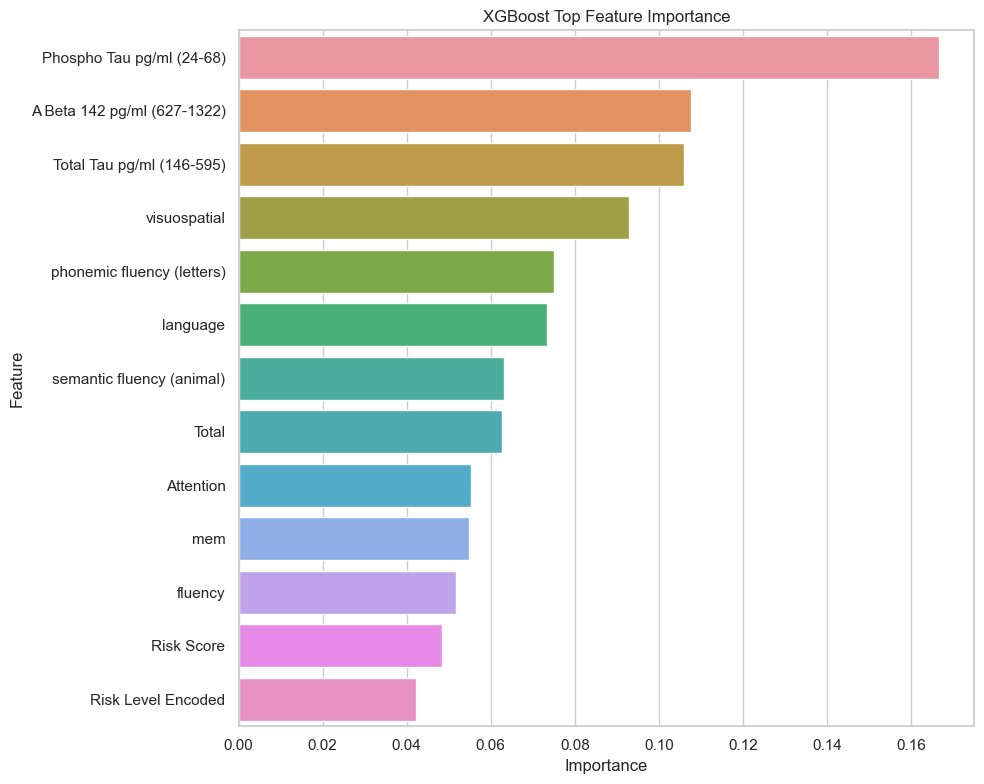

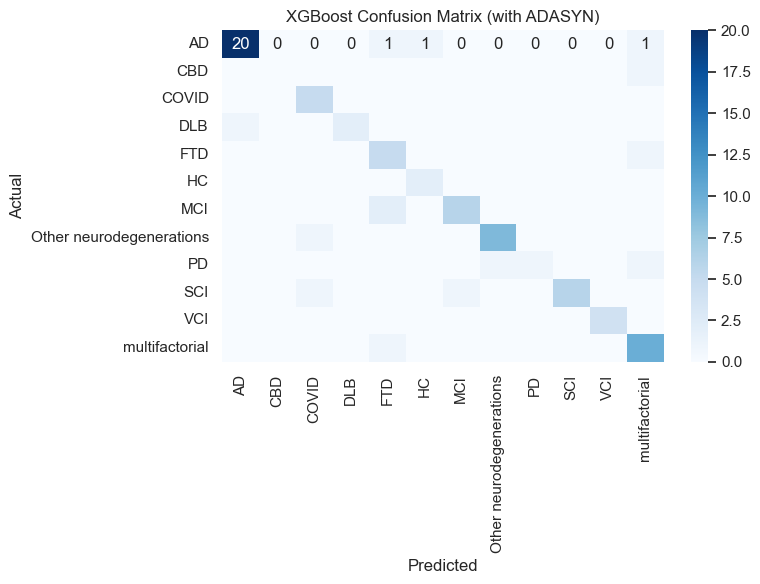

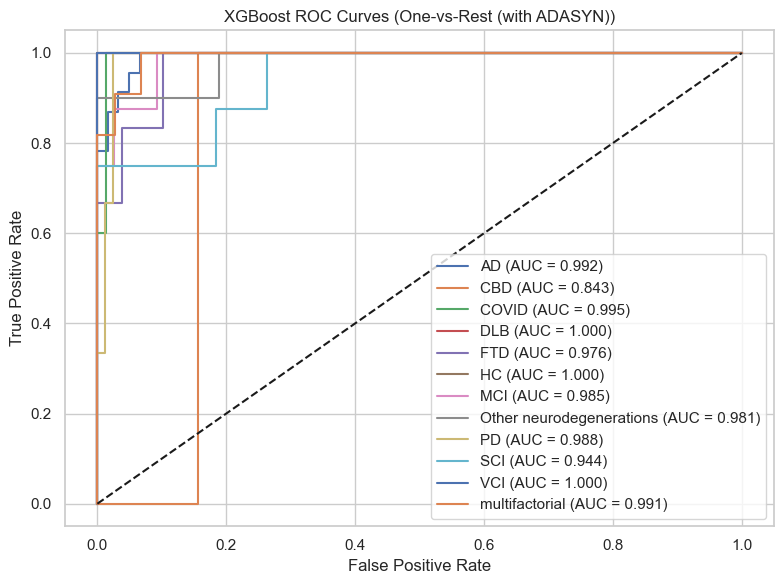

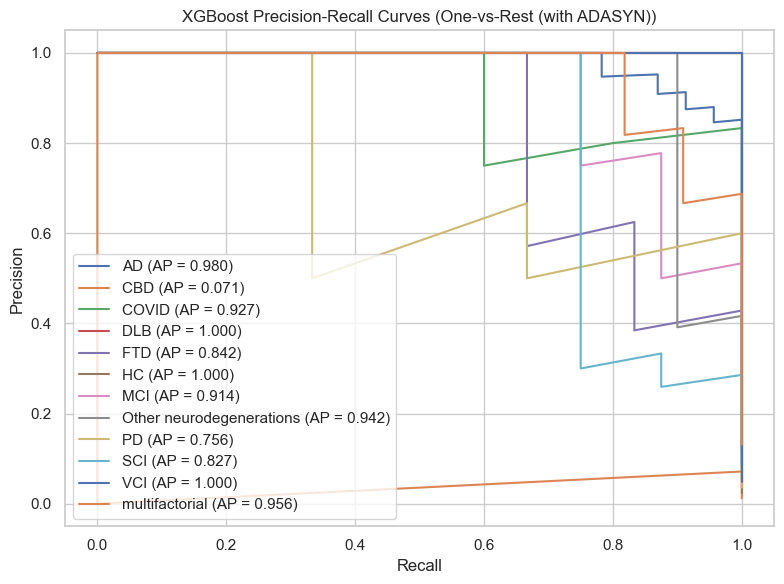


XGBoost model training and evaluation complete.

Building RandomForest Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]
Cross-validation accuracy (default params): 0.9452 ± 0.0110

Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9516

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.8452
ROC AUC: 0.9718

Confusion Mat

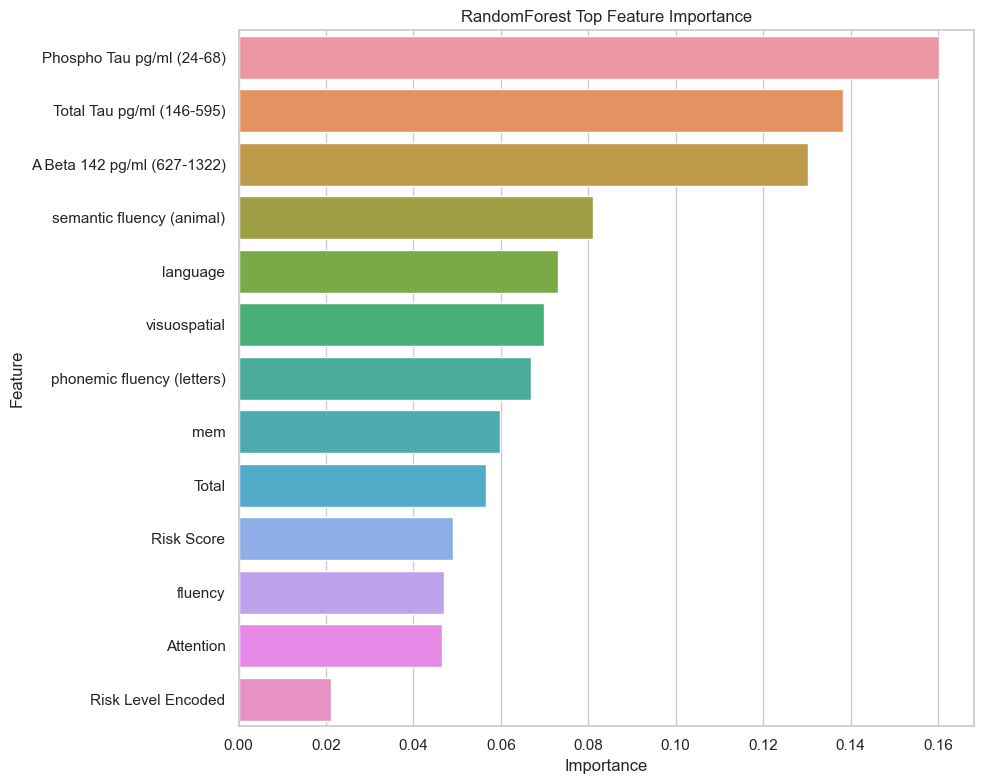

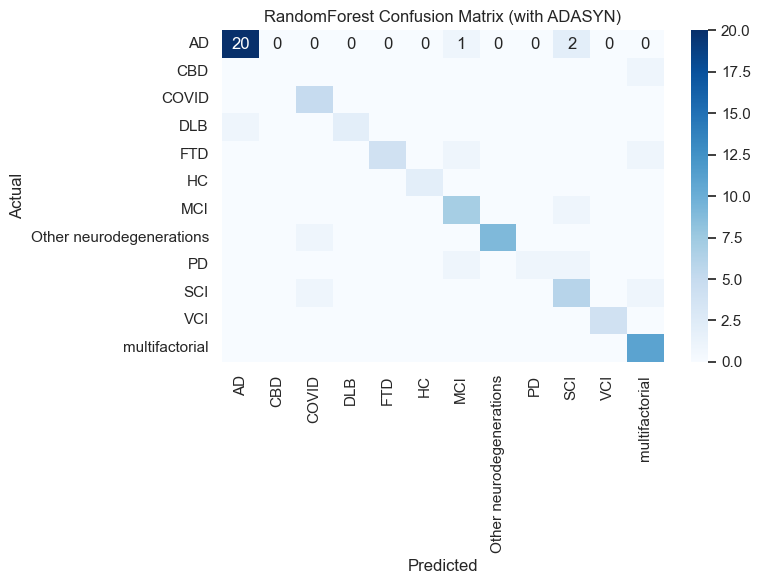

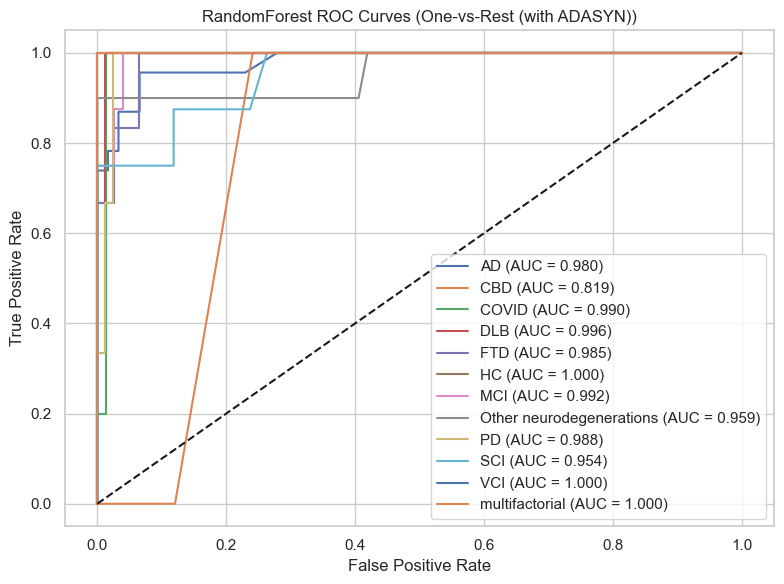

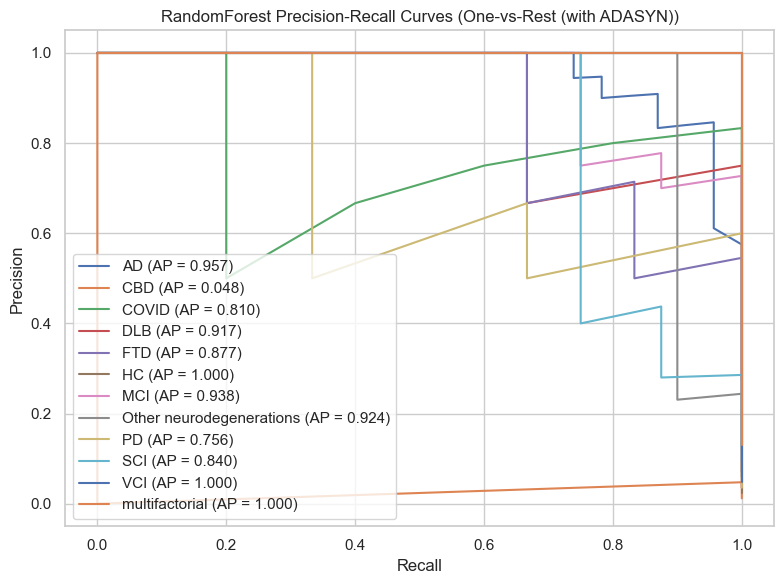


RandomForest model training and evaluation complete.

Building DecisionTree Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]
Cross-validation accuracy (default params): 0.8151 ± 0.0240

Performing hyperparameter tuning...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.8278

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.7500
ROC AUC: 0.8248

Confusion Matrix:
[[18  0

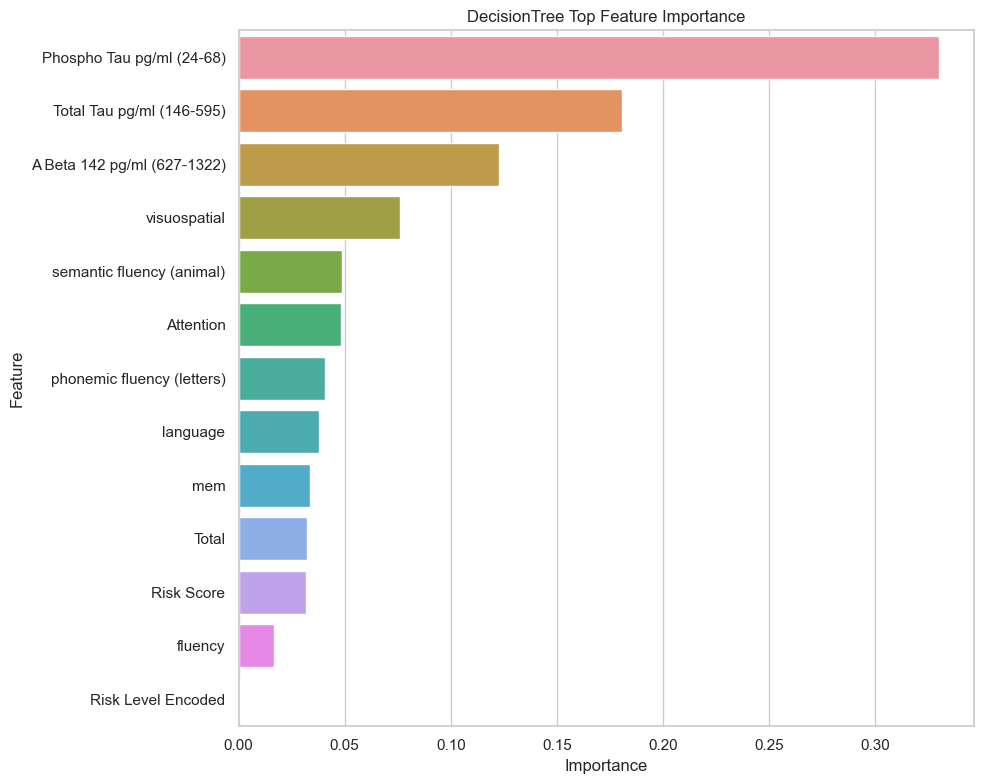

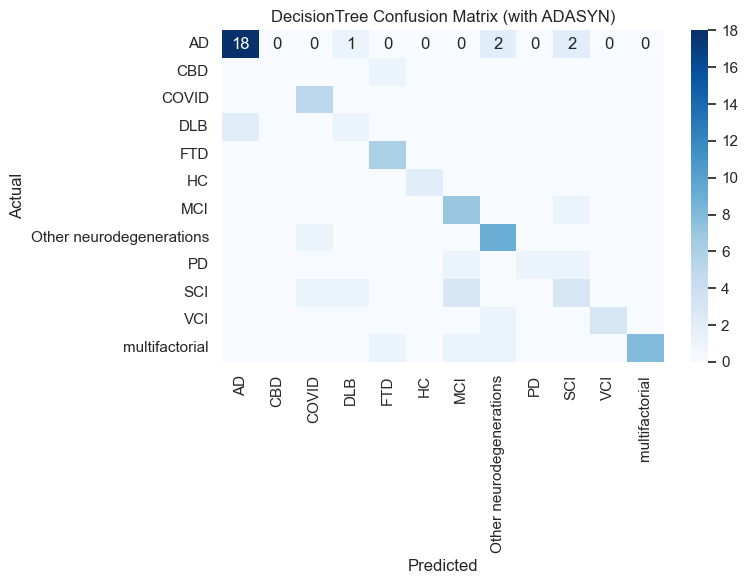

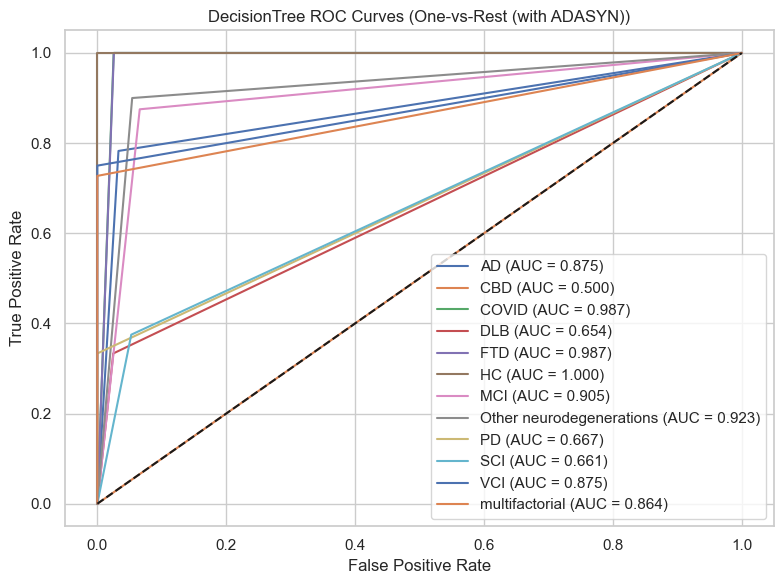

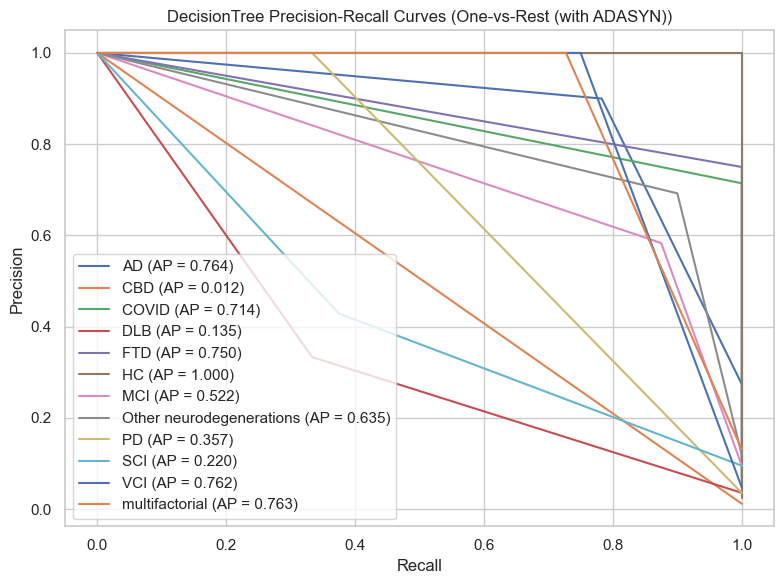


DecisionTree model training and evaluation complete.

Building SVM Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]
Cross-validation accuracy (default params): 0.7908 ± 0.0160

Performing hyperparameter tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
Best cross-validation score: 0.9605

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.6548
ROC AUC: 0.9440

Confusion Matrix:
[[19  0  0  0  2  0  0  1  0  0  0  1]
 [

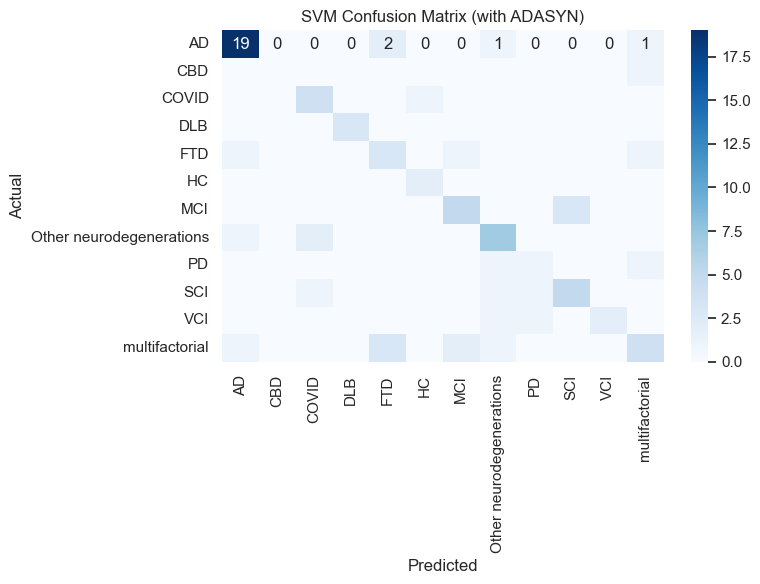

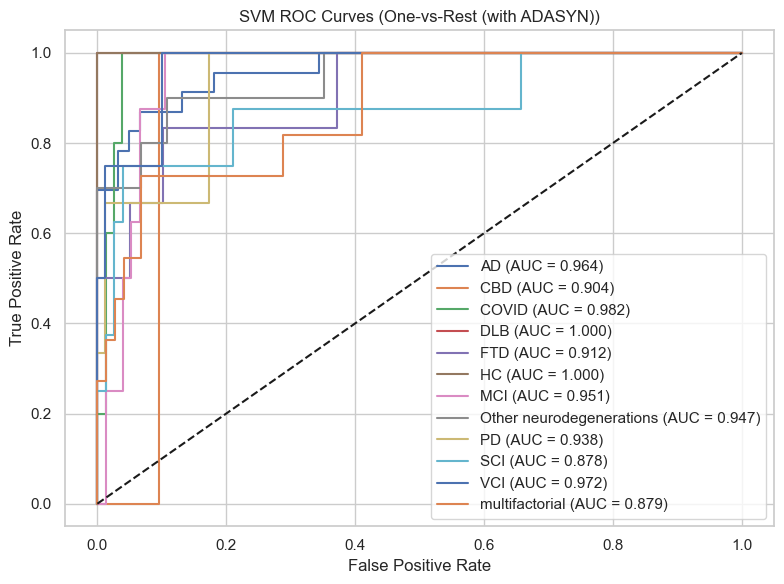

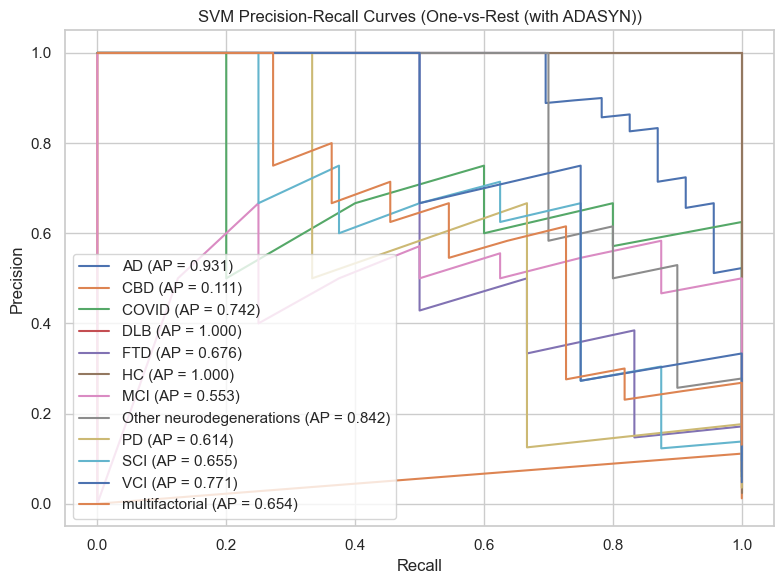


SVM model training and evaluation complete.

Building NeuralNetwork Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]
Cross-validation accuracy (default params): 0.5906 ± 0.0834

Performing hyperparameter tuning...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best cross-validation score: 0.7743

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.7262
ROC AUC: 0.9492

Conf

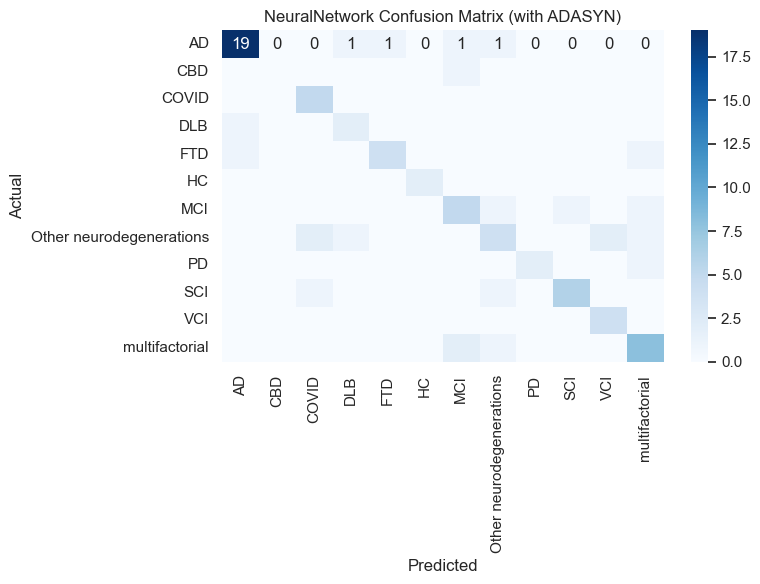

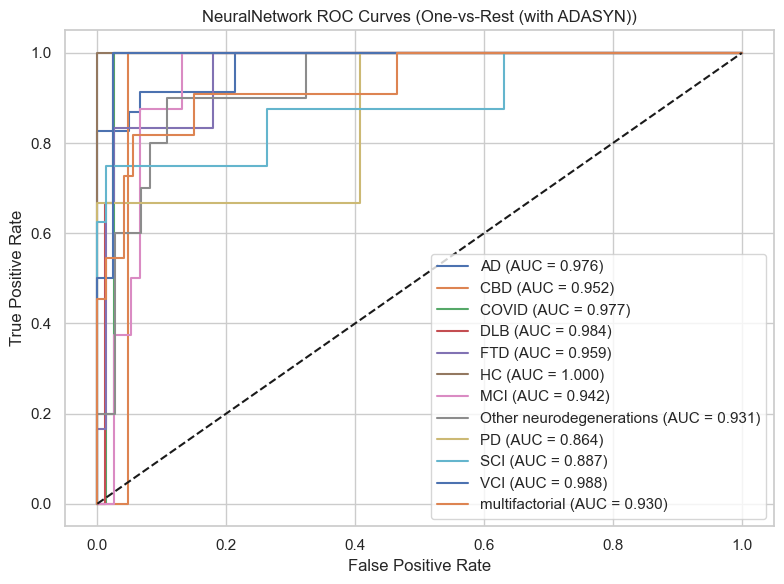

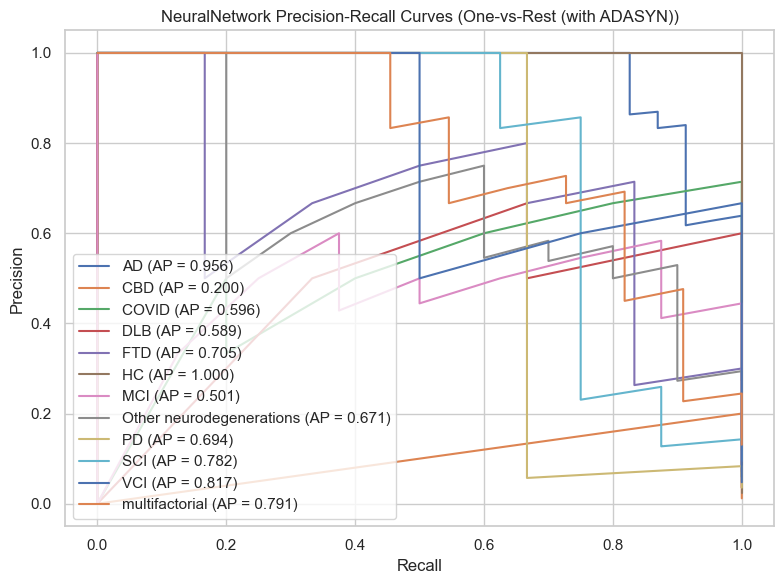


NeuralNetwork model training and evaluation complete.

Building KNN Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]
Cross-validation accuracy (default params): 0.7526 ± 0.0421

Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best cross-validation score: 0.9108

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.6548
ROC AUC: 0.8237

Confusion Matrix:
[[16  0  1  1  0  0  2  1  0  1  

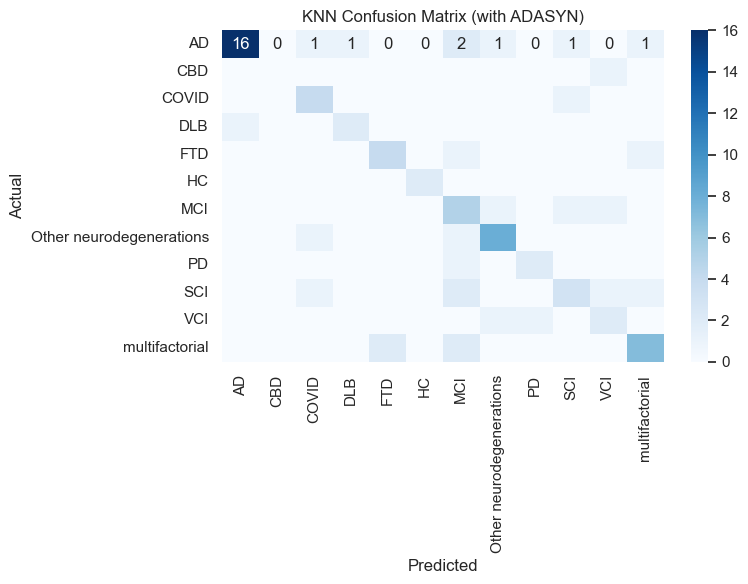

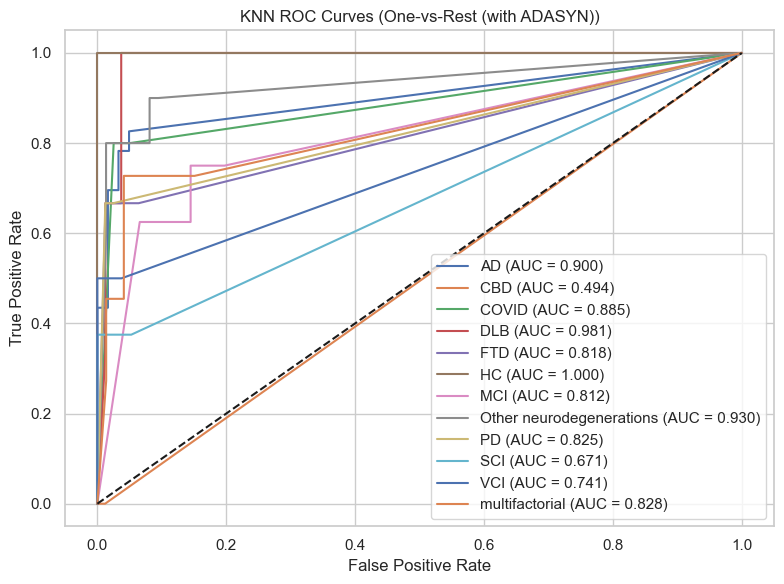

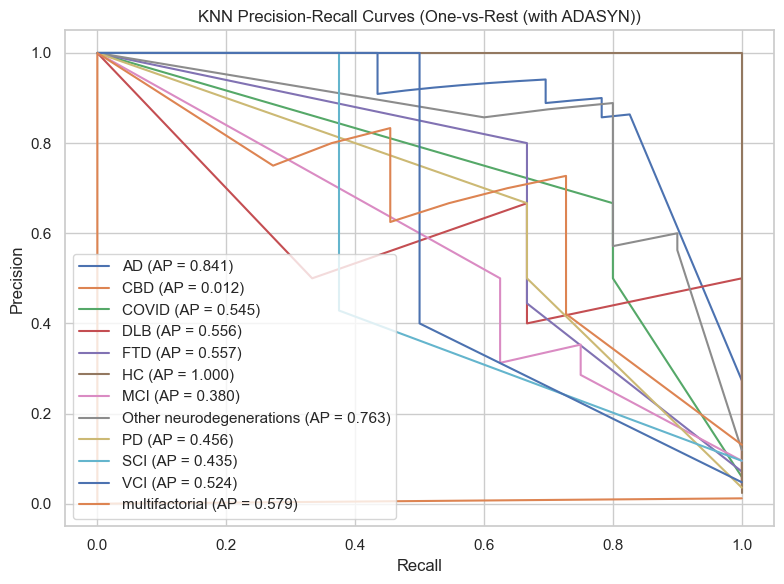


KNN model training and evaluation complete.

Building StackingEnsemble Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]
Cross-validation accuracy: 0.9349 ± 0.0148

Training final stacking ensemble model...

Test Set Performance:
Accuracy: 0.8333
ROC AUC: 0.9788

Confusion Matrix:
[[20  0  0  0  1  0  0  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  5  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  1  0  0]
 [

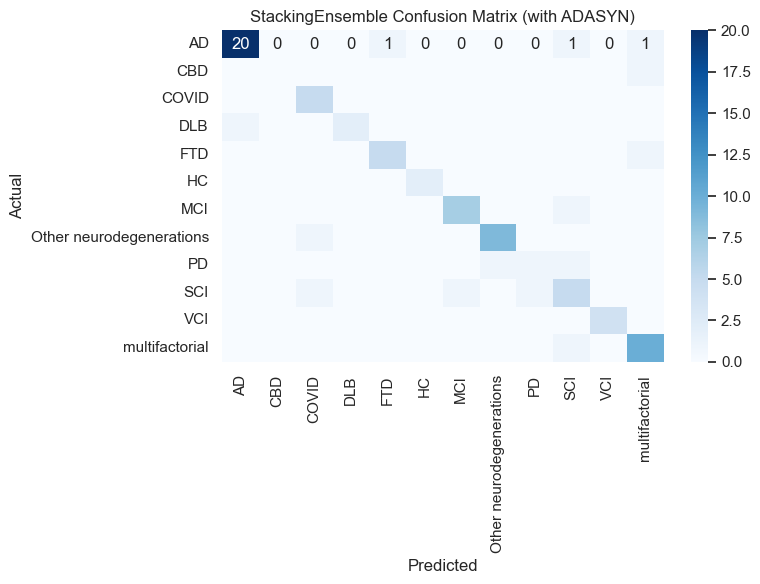

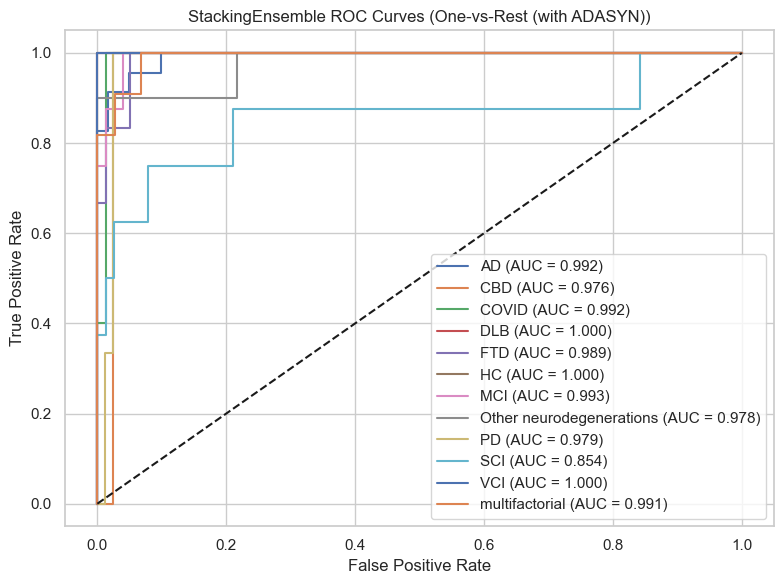

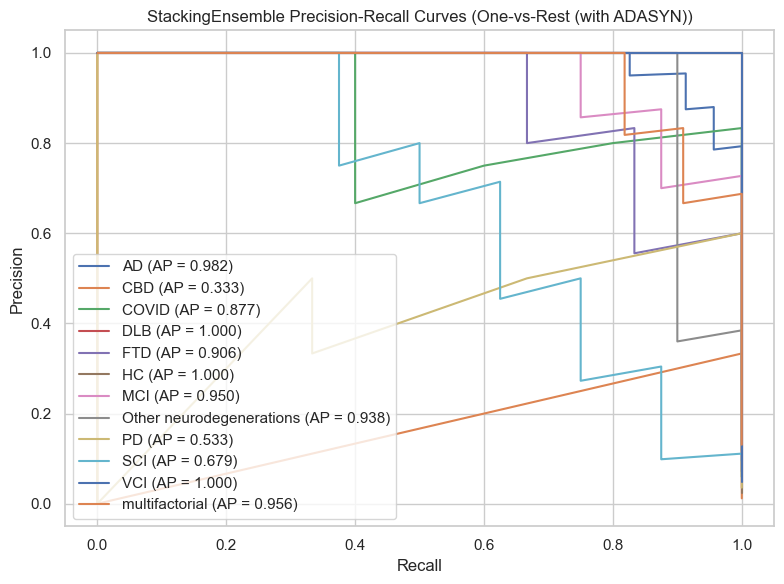


StackingEnsemble model training and evaluation complete.

Building GaussianNaiveBayes Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]
Cross-validation accuracy (default params): 0.6134 ± 0.0385

Performing hyperparameter tuning...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'var_smoothing': 1e-09}
Best cross-validation score: 0.6134

Training final model on full dataset...

Test Set Performance:
Accuracy: 0.5952
ROC AUC: 0.9141

Confusion Matrix:
[[17  0  0  3  0  0  0  0  0  2  0  1]
 [ 0  0  0  0  0  0  1  0  0  0

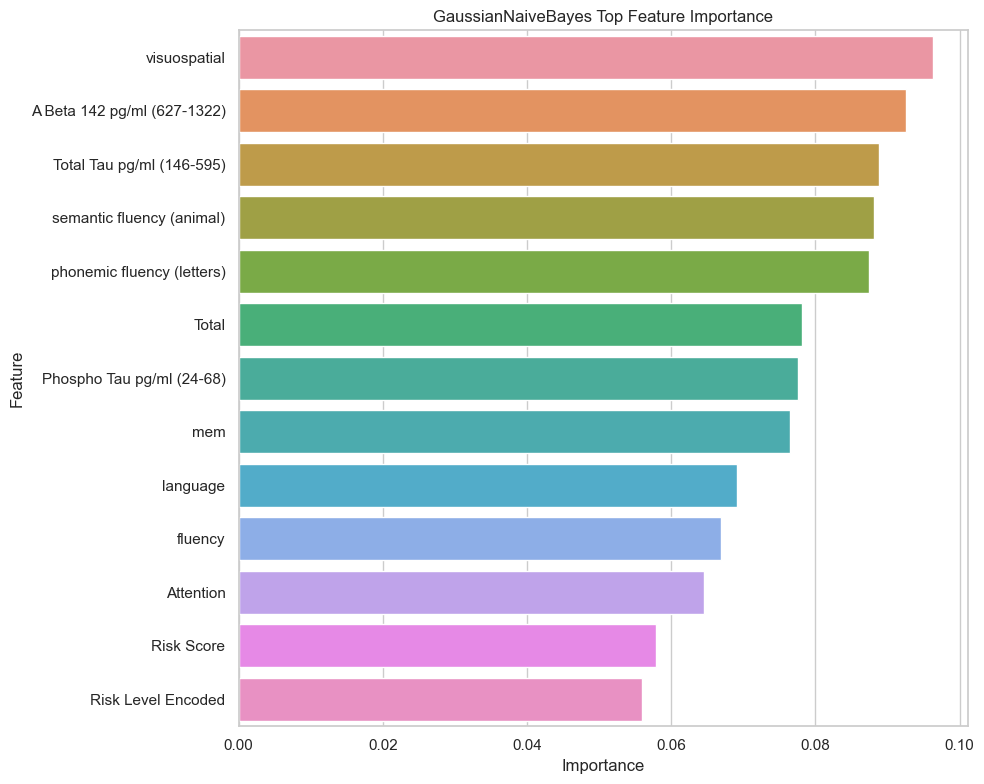

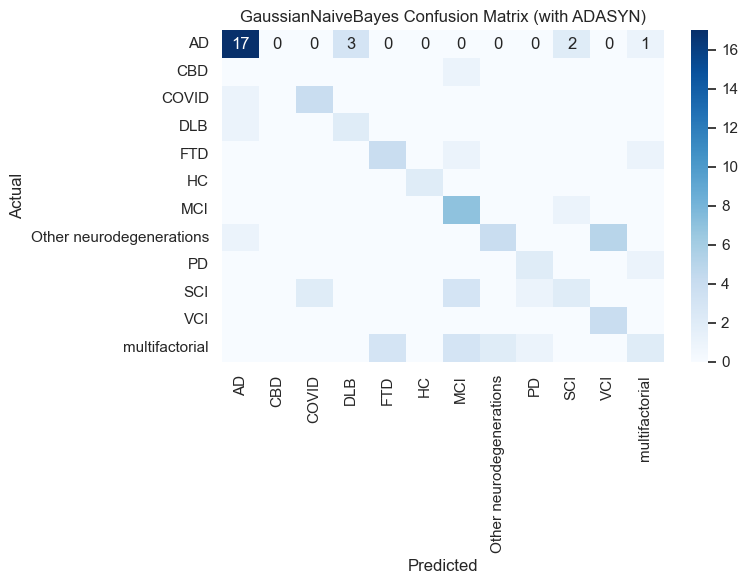

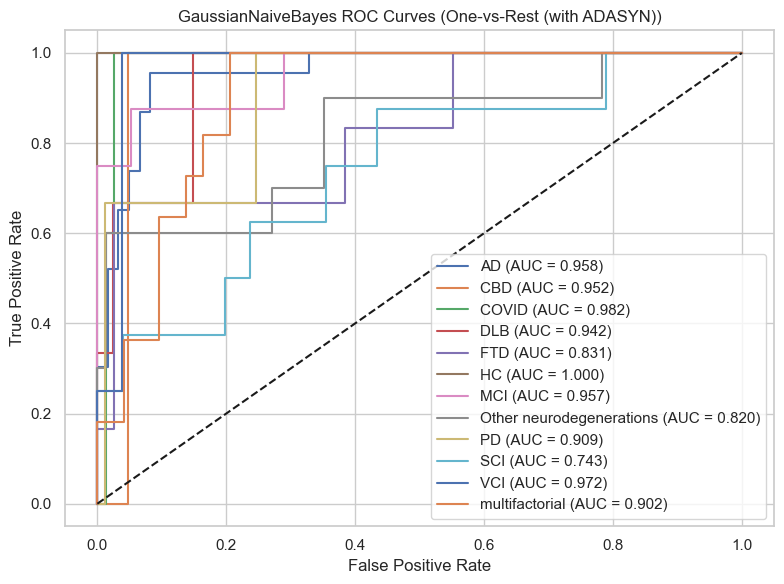

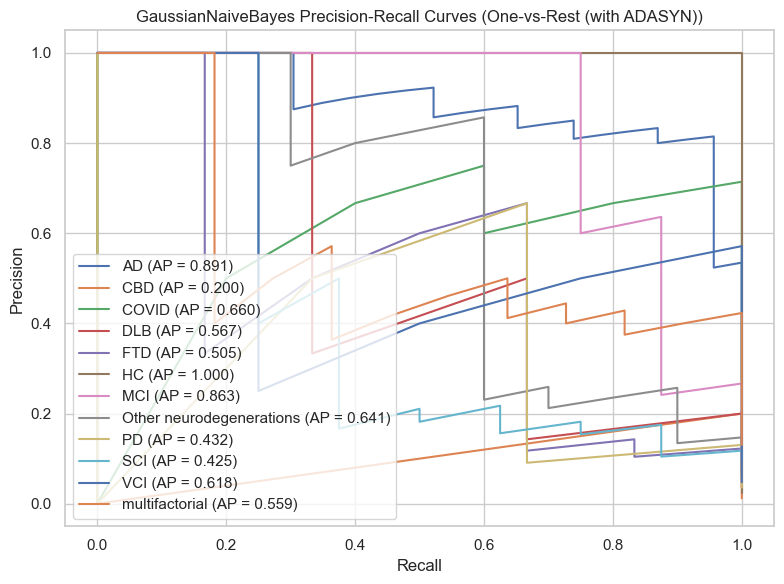


GaussianNaiveBayes model training and evaluation complete.

Building SelfNormalizingNN (SNN) Model with PyTorch
Using device: cpu
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]

Training PyTorch model with early stopping...
Epoch 10/200, Train Loss: 1.6236, Val Loss: 1.3975
Epoch 20/200, Train Loss: 1.1786, Val Loss: 1.0501
Epoch 30/200, Train Loss: 1.1812, Val Loss: 0.9071
Epoch 40/200, Train Loss: 0.9764, Val Loss: 0.7982
Epoch 50/200, Train Loss: 0.8284, Val Loss: 0.8544
Epoch 60/200, Train Loss: 0.8052, Val Loss: 0.8321
Epoch 70/200, Train Loss: 0.76

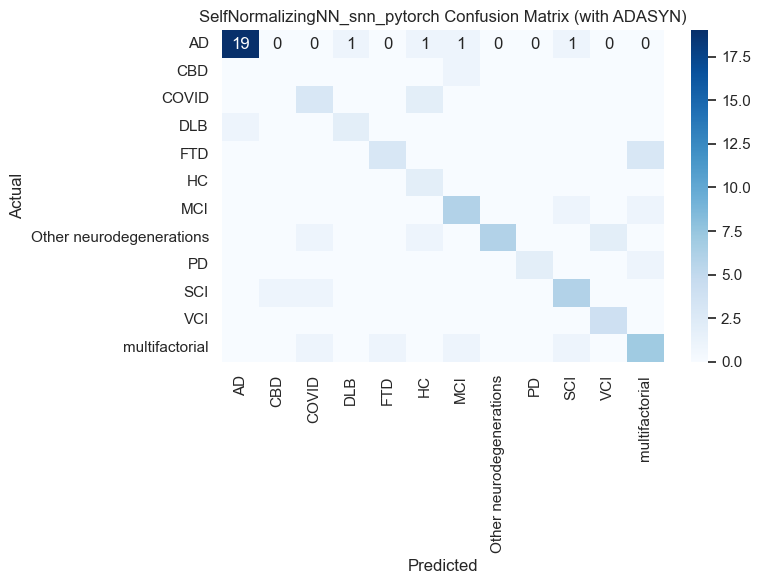

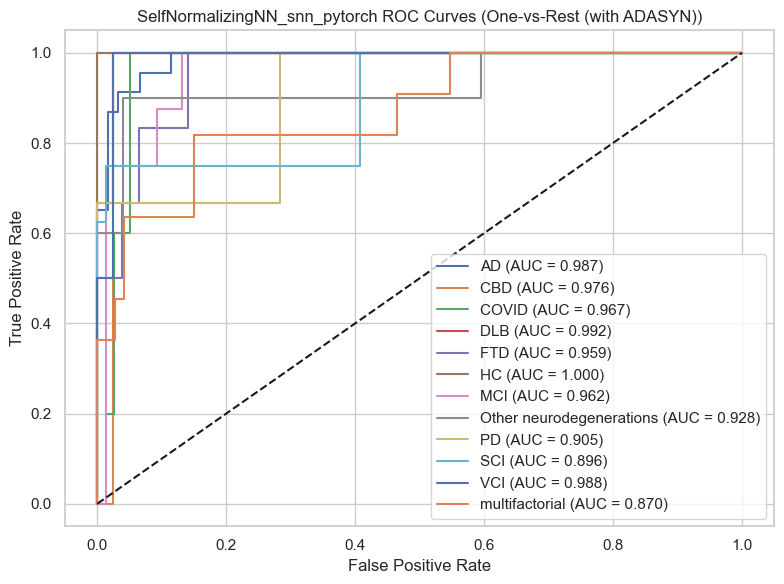

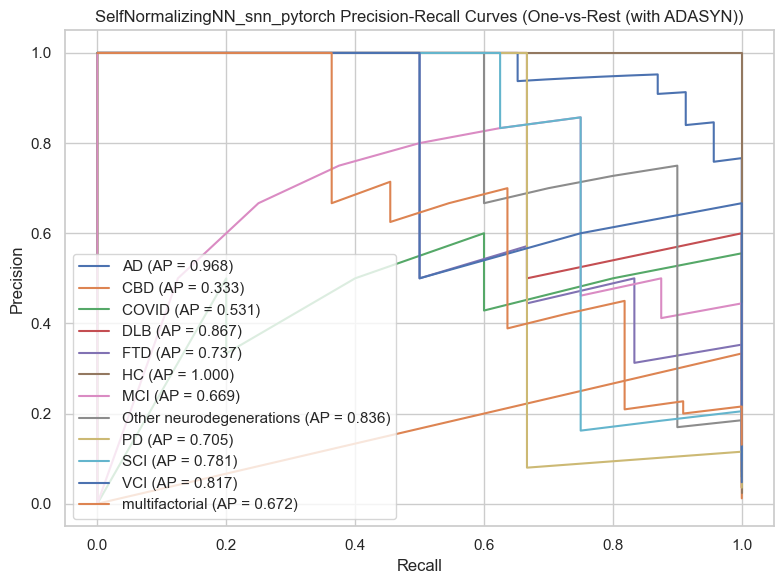

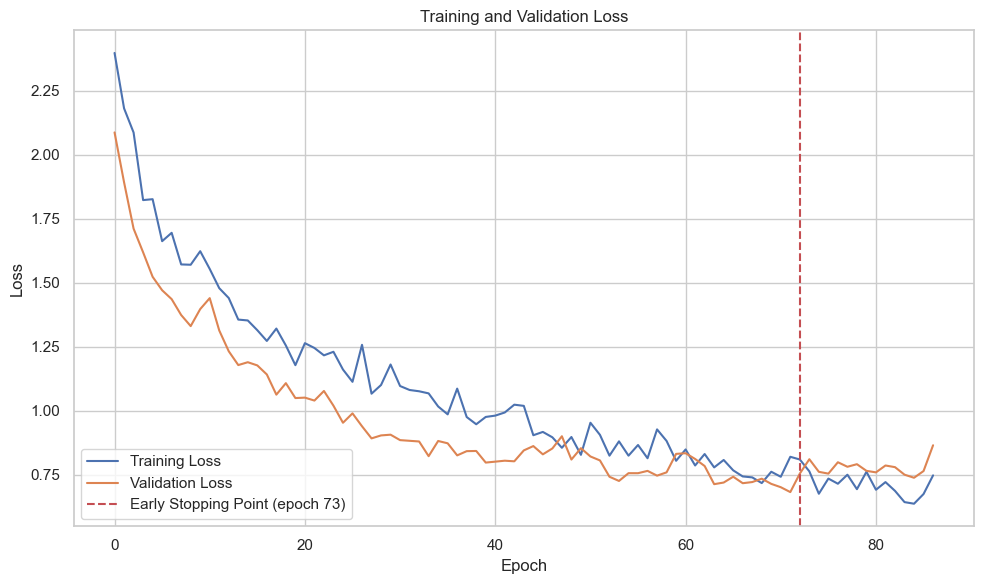


SelfNormalizingNN (snn) PyTorch model training and evaluation complete.

Building AttentionNN (ATT) Model with PyTorch
Using device: cpu
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Trying ADASYN.
After ADASYN - Training set size: 784
Class distribution after ADASYN: [89 62 65 59 61 62 63 68 59 66 64 66]

Training PyTorch model with early stopping...
Epoch 10/200, Train Loss: 2.0743, Val Loss: 2.1896
Epoch 20/200, Train Loss: 1.8478, Val Loss: 1.9593
Epoch 30/200, Train Loss: 1.7049, Val Loss: 1.8256
Epoch 40/200, Train Loss: 1.5628, Val Loss: 1.7679
Epoch 50/200, Train Loss: 1.4124, Val Loss: 1.7900
Epoch 60/200, Train Loss: 1.6836, Val Loss: 1.6503
Epoch 70/200, Train Los

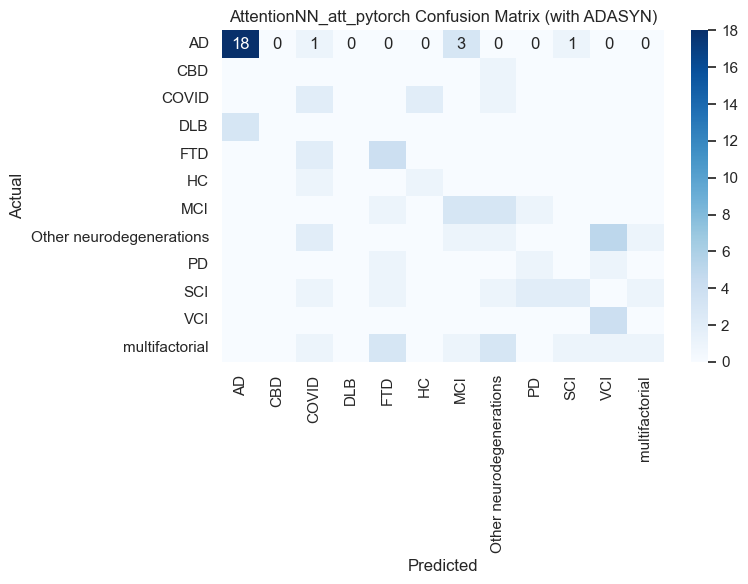

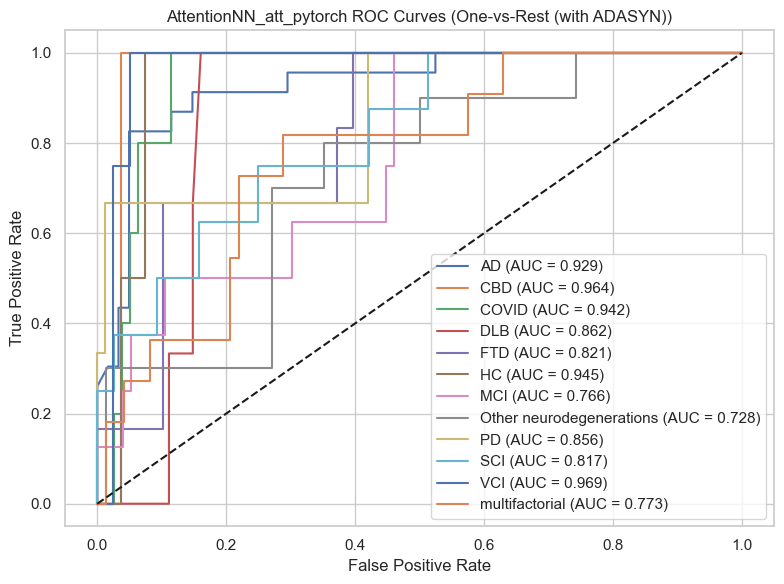

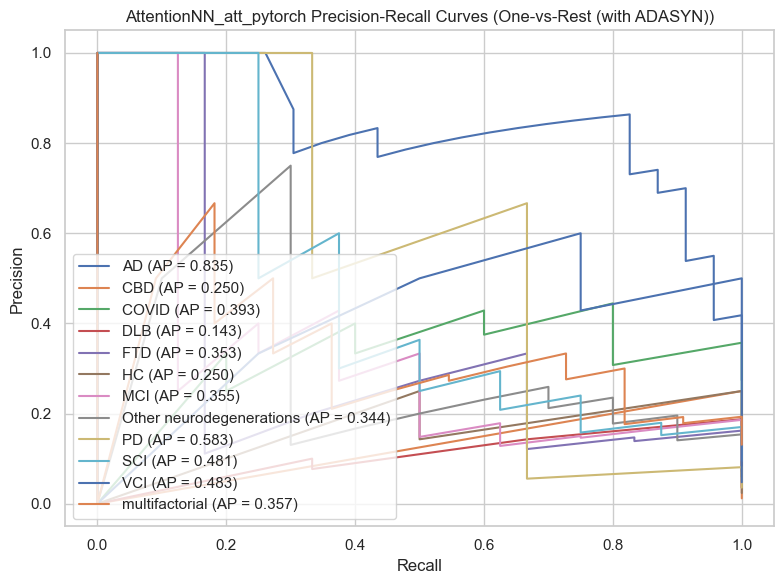

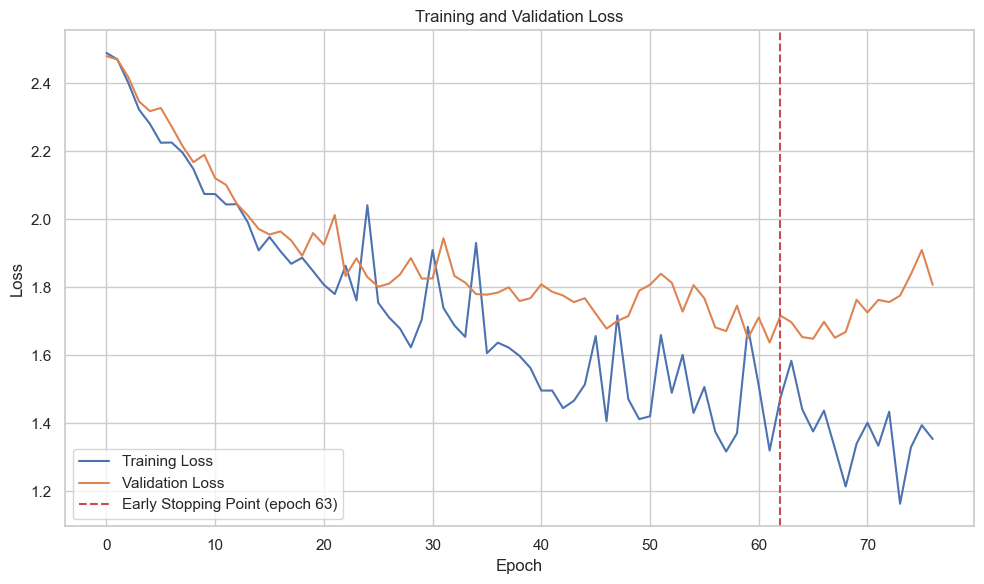


AttentionNN (att) PyTorch model training and evaluation complete.

Model Comparison (Accuracy):
                Model  Accuracy   ROC_AUC
1        RandomForest  0.845238  0.971827
0             XGBoost  0.833333  0.974688
6    StackingEnsemble  0.833333  0.978826
2        DecisionTree  0.750000  0.824818
4       NeuralNetwork  0.726190  0.949202
8   SelfNormalizingNN  0.714286  0.952633
3                 SVM  0.654762  0.943961
5                 KNN  0.654762  0.823711
7  GaussianNaiveBayes  0.595238  0.914125
9         AttentionNN  0.440476  0.864401

Model Comparison (ROC AUC):
                Model  Accuracy   ROC_AUC
6    StackingEnsemble  0.833333  0.978826
0             XGBoost  0.833333  0.974688
1        RandomForest  0.845238  0.971827
8   SelfNormalizingNN  0.714286  0.952633
4       NeuralNetwork  0.726190  0.949202
3                 SVM  0.654762  0.943961
7  GaussianNaiveBayes  0.595238  0.914125
9         AttentionNN  0.440476  0.864401
2        DecisionTree  0.750000  0

In [3]:

if __name__ == "__main__":
    # Path to your imputed data
    data_path = 'cognid_with_risk_scores.xlsx'
    cleaned_data_path = 'cognid_with_risk_scores_cleaned.xlsx'
    
    # Cleaning the data
    df = pd.read_excel(data_path)
    
    # Removing rows for whom the data for medical reports is not present
    if 'Risk Score' in df.columns:
        missing_count = df['Risk Score'].isna().sum()
        if missing_count > 0:
            print(f"Imputing {missing_count} missing values in 'Risk Score' with 0")
            df['Risk Score'] = df['Risk Score'].fillna(0)
    
    if 'Risk Level' in df.columns:
        missing_count = df['Risk Level'].isna().sum()
        if missing_count > 0:
            print(f"Imputing {missing_count} missing values in 'Risk Level' with 'Not Recorded'")
            df['Risk Level'] = df['Risk Level'].fillna('Not Recorded')

    label_encoder = LabelEncoder()
    df['Risk Level Encoded'] = label_encoder.fit_transform(df['Risk Level'])
    print("Label Encoding complete")
    
    # Target column (diagnosis classification)
    target_column = 'Completed Diagnosis'
    
    # Removing Rows where diagnosis is still under investigation
    before_rows = df.shape[0]
    df = df.drop(df[df[target_column]=='No diagnosis'].index)
    
    print(f'Removed {before_rows - df.shape[0]} rows from {target_column} where value was No diagnosis')
    
    df.to_excel(cleaned_data_path, index=False)
    
    
    # Features to use (these should match the imputed columns)
    feature_columns = [
        'Total Tau pg/ml (146-595)', 
        'Phospho Tau pg/ml (24-68)', 
        'A Beta 142 pg/ml (627-1322)', 
        'Total', 
        'Attention', 
        'mem', 
        'fluency', 
        'language', 
        'visuospatial', 
        'phonemic fluency (letters)', 
        'semantic fluency (animal)',
        'Risk Score',
        'Risk Level Encoded'
    ]
    
    # Run all models and get comparison
    models_results, comparison = main(
        data_path=cleaned_data_path,
        target_column=target_column,
        feature_columns=feature_columns,
        models_to_run=['xgboost', 'rf', 'dt', 'svm', 'nn', 'knn', 'stack', 'gnb', 'snn', 'att'],  # Run all models
        test_size=0.2,
        use_adasyn=True,
        adasyn_neighbors=6,
        random_state=42
    )
    print(len(models_results))
    
    # Alternatively, run only specific models
    # models_results, comparison = main(
    #     data_path=data_path,
    #     target_column=target_column,
    #     feature_columns=feature_columns,
    #     models_to_run=['xgboost', 'rf'],  # Only run XGBoost and Random Forest
    #     test_size=0.3,
    #     use_adasyn=True,
    #     random_state=42
    # )

In [39]:
from diagnostic_models import load_and_prepare_data

X, y, feature_columns, class_names = load_and_prepare_data('cognid_with_risk_scores.xlsx', target_column, feature_columns)

Loaded data with 388 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'No diagnosis'
 'Other neurodegenerations' 'PD' 'SCI' 'VCI' 'multifactorial']


Imputing 51 missing values in 'Risk Score' with 0
Imputing 51 missing values in 'Risk Level' with 'Not Recorded'
Label Encoding complete
Removed 16 rows from Completed Diagnosis where value was No diagnosis

Building XGBoost Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.925) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ................................ score: (test=0.938) total time=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ................................ score: (test=0.943) total time=   0.2s
[CV] END ................................ score: (test=0.957) total time=   0.2s
[CV] END ................................ score: (test=0.943) total time=   0.2s
Cross-validation accuracy (default params): 0.9413 ± 0.0105

Performing hyperparameter tuning...
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.9536

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.8214
ROC AUC: 0.9748

Confusion Matrix:
[[21  0  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  5  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  6  0  0  1  0  0]
 [ 0  0  1  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  2  0  0  0]
 [ 0  0  1  0  0  0  2  0  1  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 11]]

Classification Report:
                          precision    recall  f1-score   support

                      AD       0.91      0.91      0.91        23
                     CBD       0.00      0.00      0.00         1
        

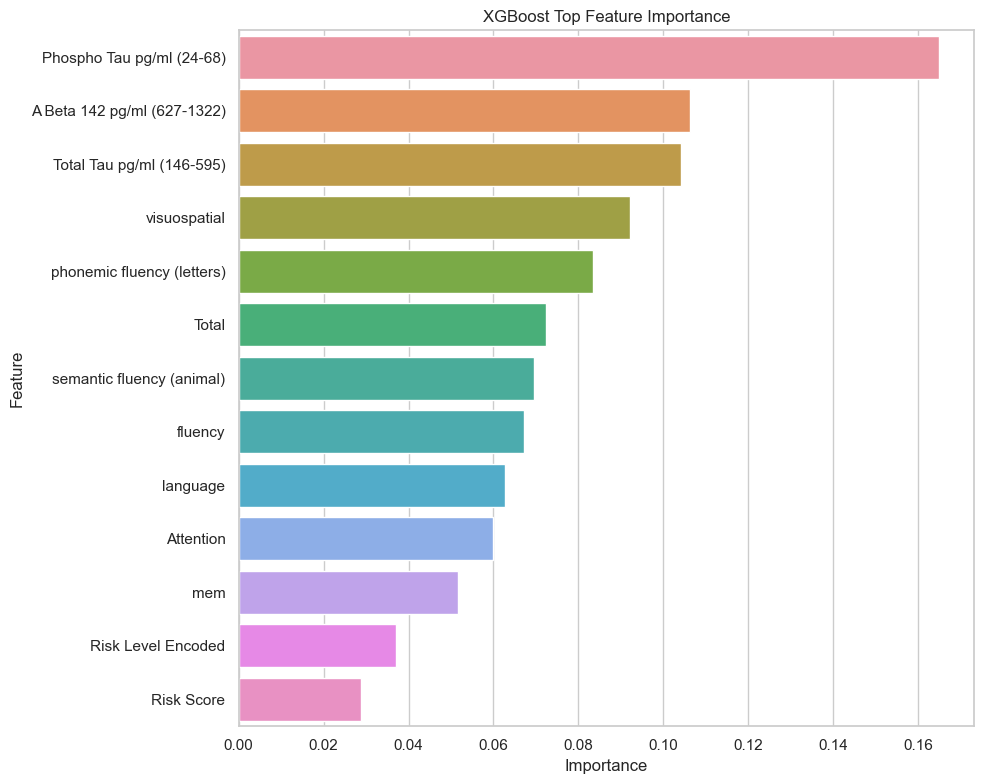

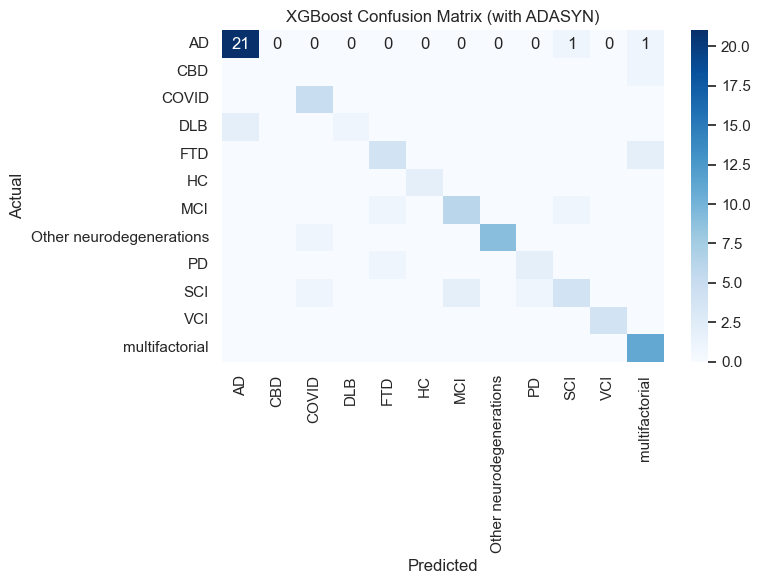

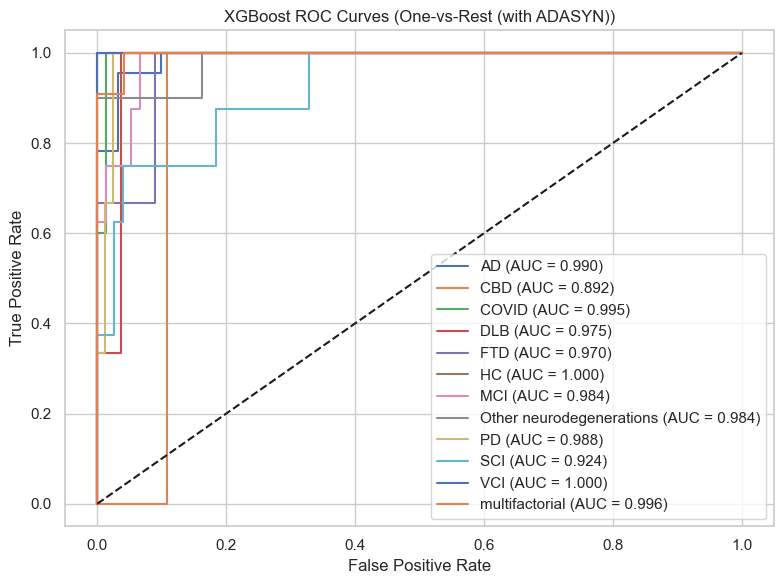

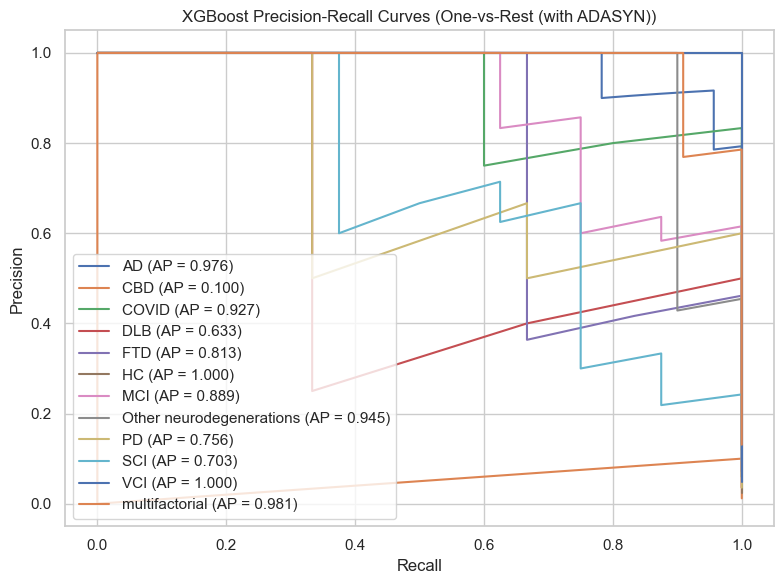


XGBoost model training and evaluation complete.

Building RandomForest Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]
Cross-validation accuracy (default params): 0.9659 ± 0.0154

Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.9716

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.8333
ROC AUC: 0.9352

Confusion 

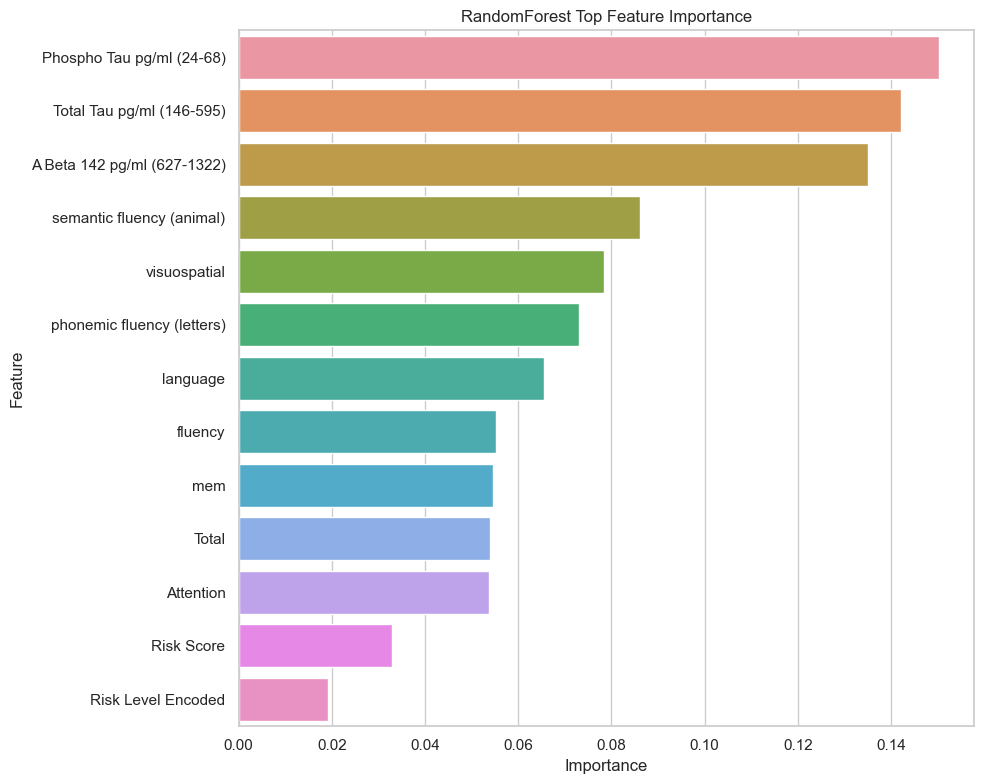

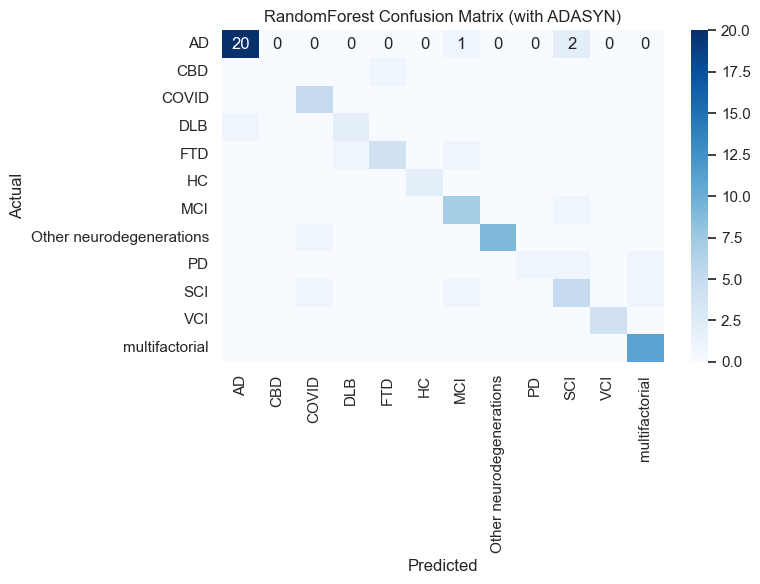

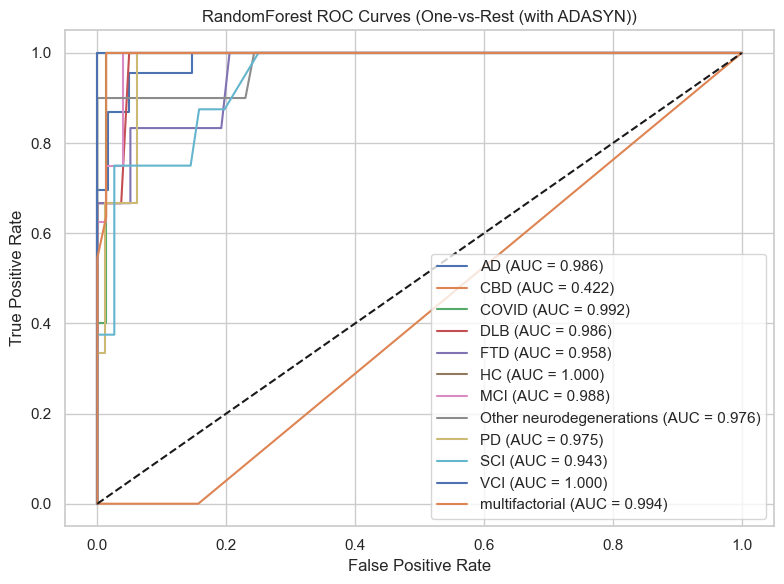

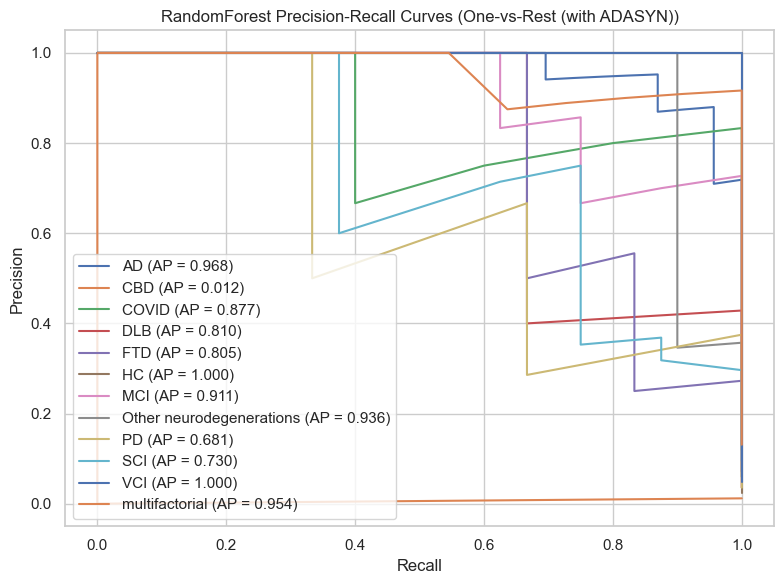


RandomForest model training and evaluation complete.

Building DecisionTree Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]
Cross-validation accuracy (default params): 0.8371 ± 0.0194

Performing hyperparameter tuning...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.8646

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.7857
ROC AUC: 0.8506

Confusion Matrix:
[[18

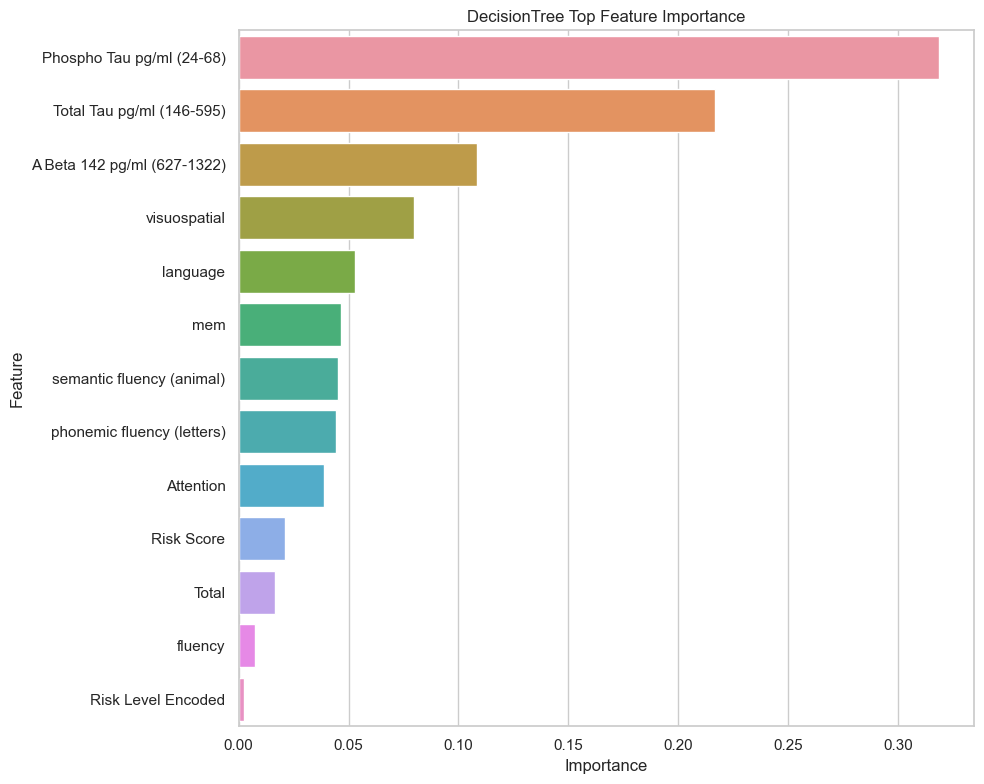

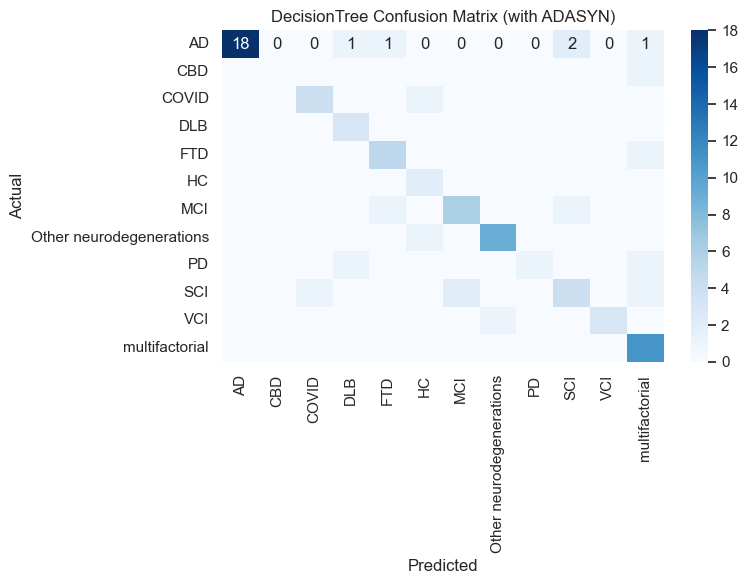

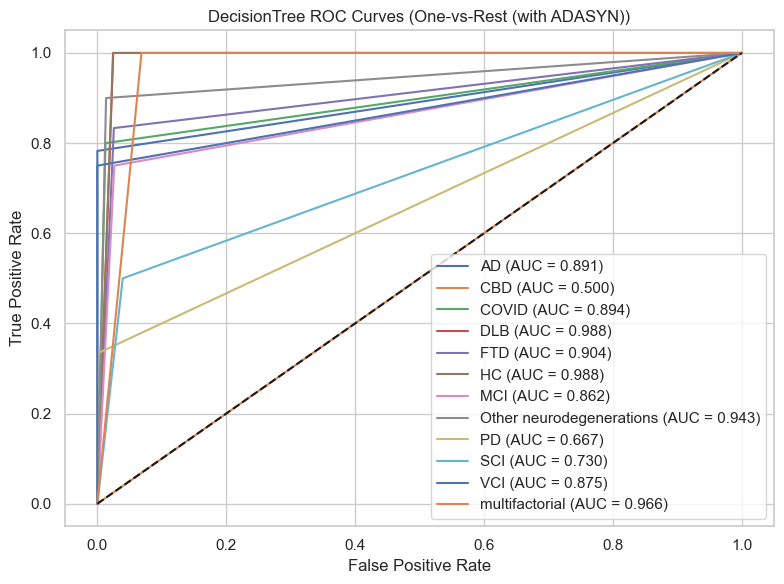

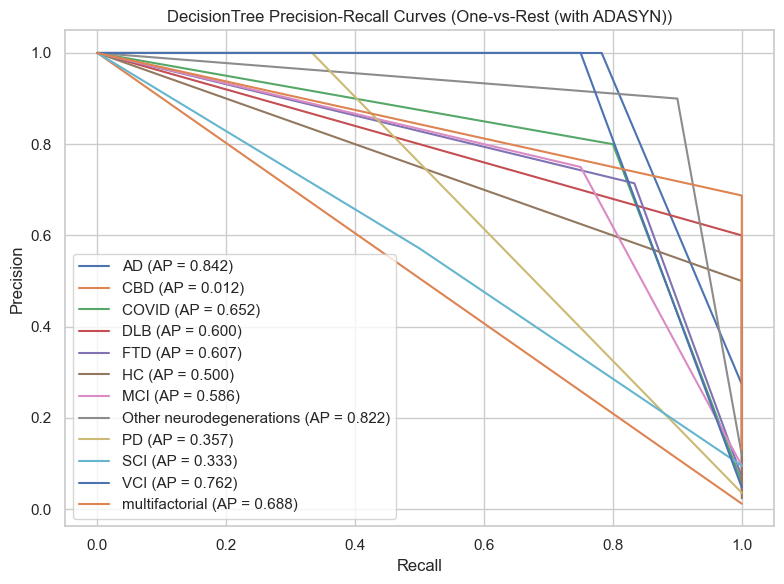


DecisionTree model training and evaluation complete.

Building SVM Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]
Cross-validation accuracy (default params): 0.8599 ± 0.0191

Performing hyperparameter tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
Best cross-validation score: 0.9811

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.6667
ROC AUC: 0.9346

Confusion Matrix:
[[20  0  0  0  1  0  0  1  0  1  0  0]

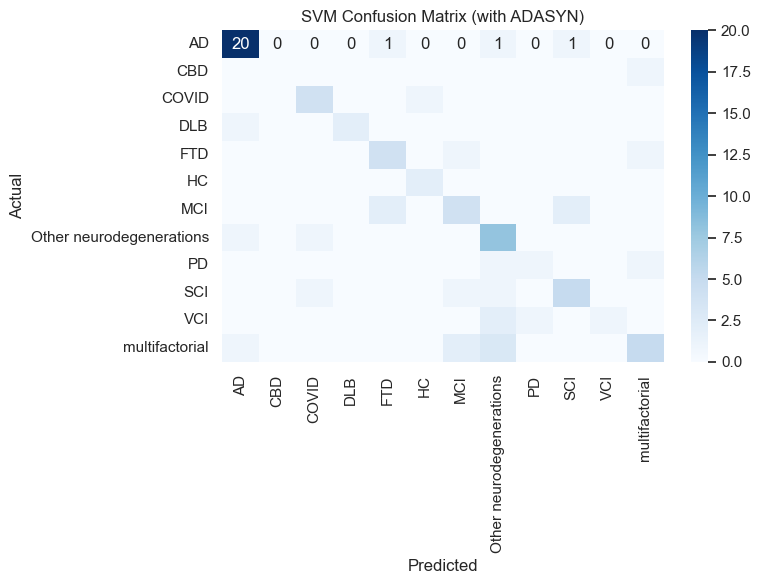

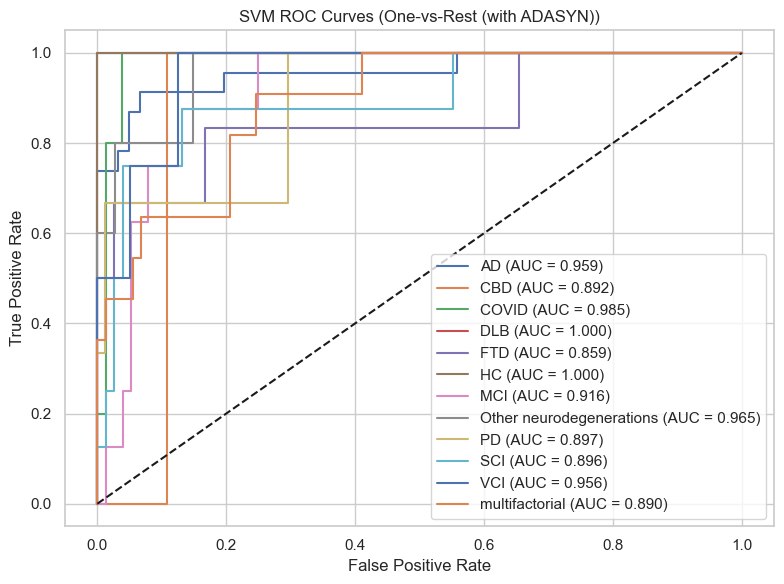

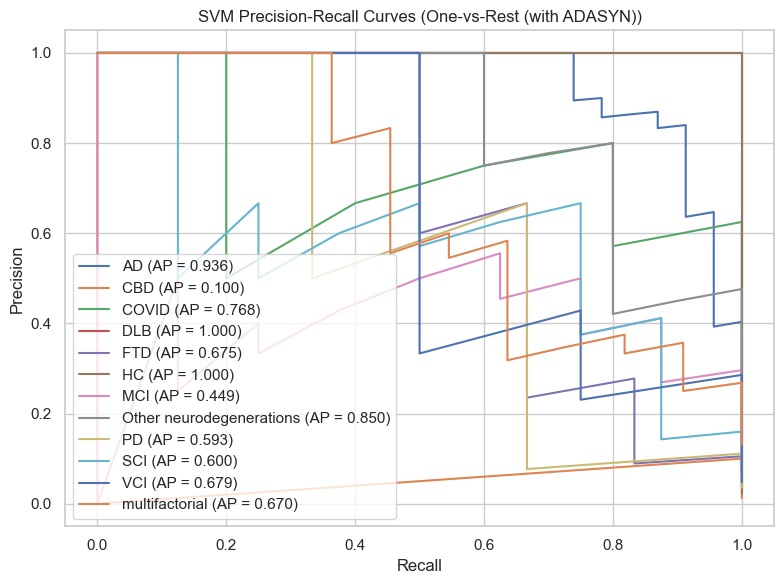


SVM model training and evaluation complete.

Building NeuralNetwork Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]
Cross-validation accuracy (default params): 0.6932 ± 0.0590

Performing hyperparameter tuning...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best cross-validation score: 0.8608

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.6667
ROC AUC: 0.9351

Co

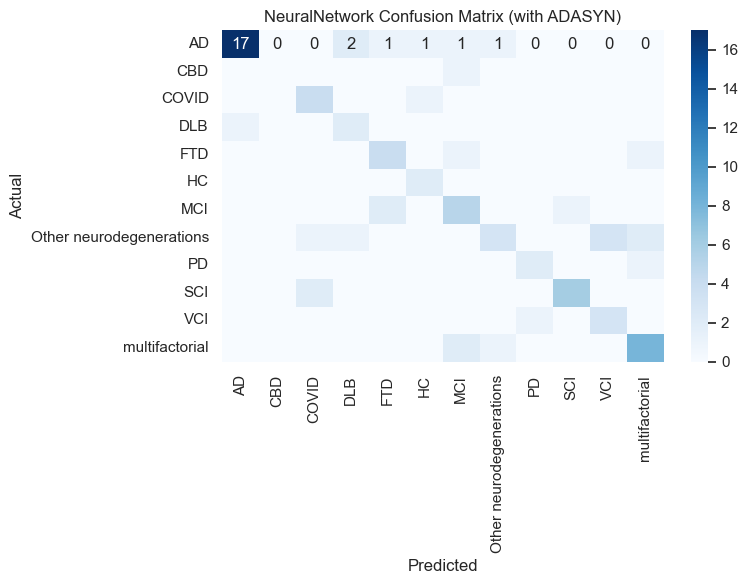

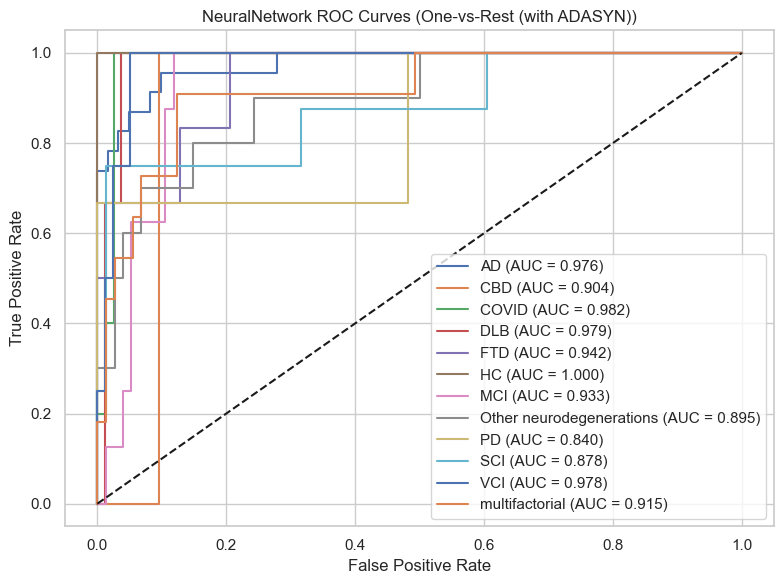

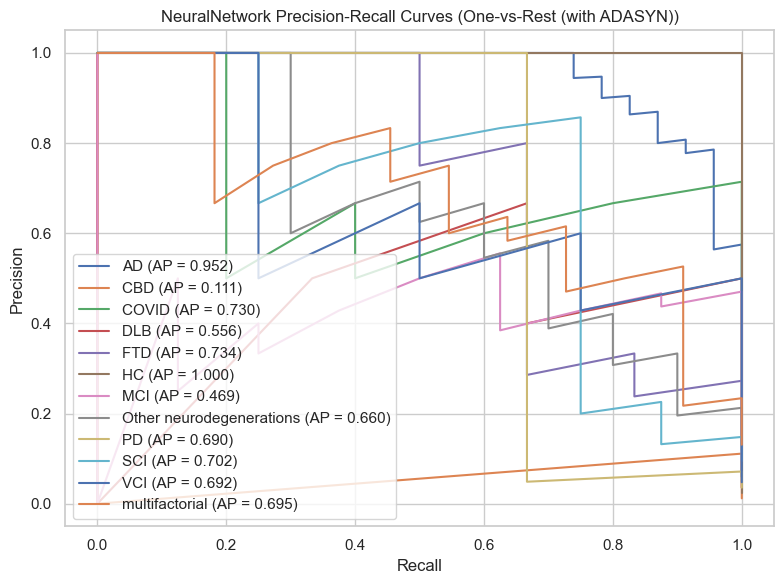


NeuralNetwork model training and evaluation complete.

Building KNN Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]
Cross-validation accuracy (default params): 0.8532 ± 0.0206

Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best cross-validation score: 0.9451

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.6310
ROC AUC: 0.8272

Confusion Matrix:
[[14  0  1  2  1  0  1  2  0  

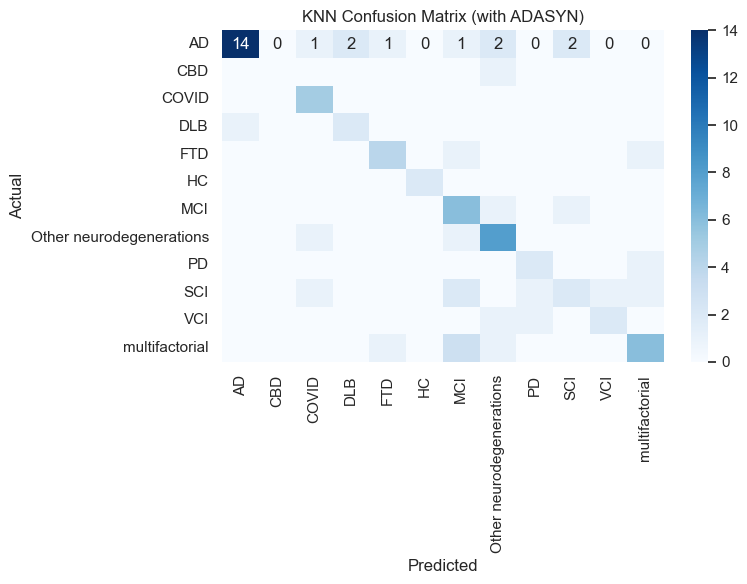

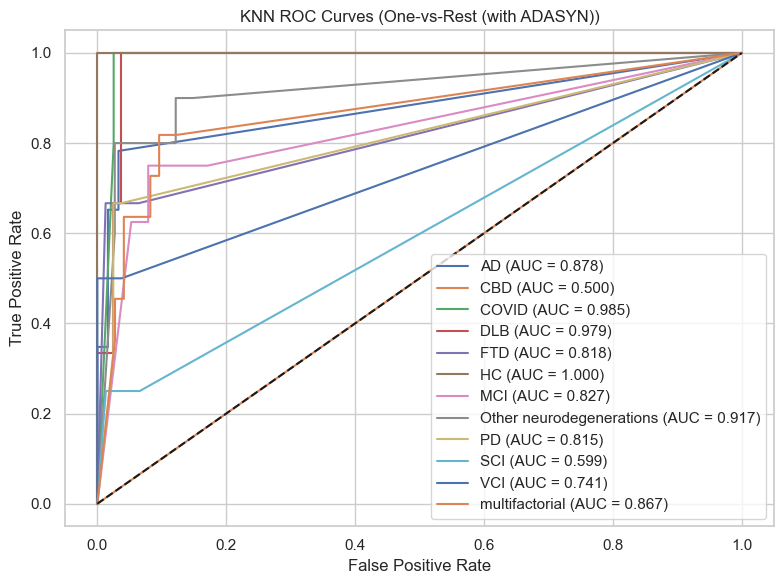

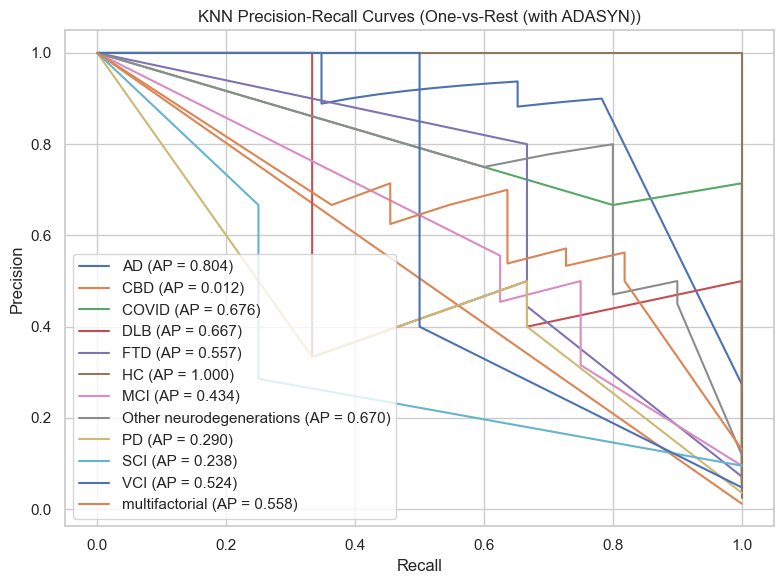


KNN model training and evaluation complete.

Building StackingEnsemble Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]
Cross-validation accuracy: 0.9640 ± 0.0114

Training final stacking ensemble model...

Test Set Performance:
Accuracy: 0.8095
ROC AUC: 0.9639

Confusion Matrix:
[[21  0  0  1  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0  5  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  1  0  0  0  0  1]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  5  0  0  1  0  1]

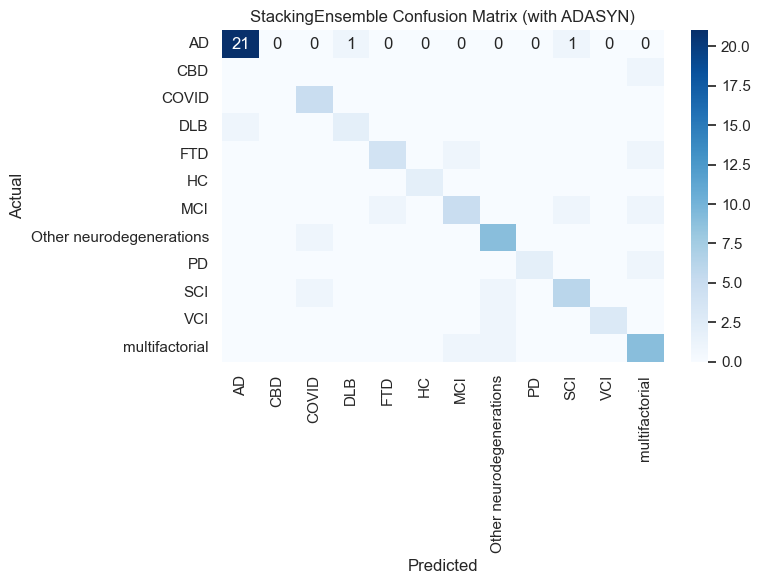

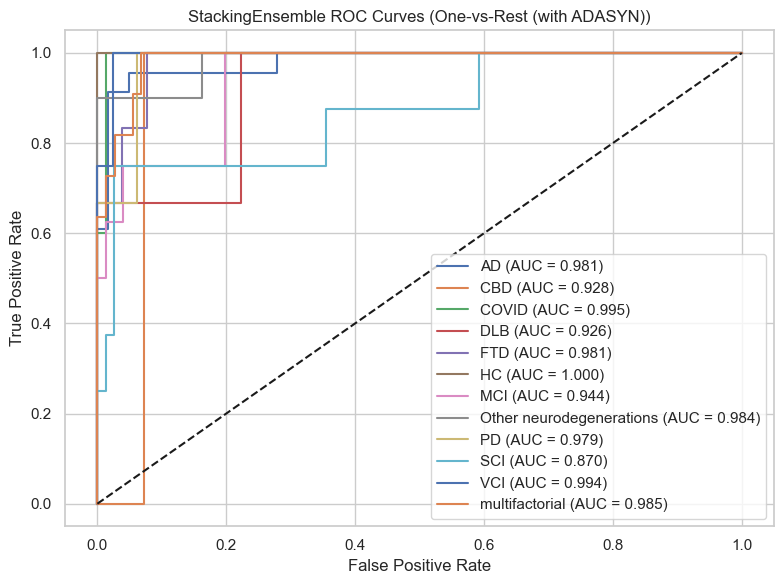

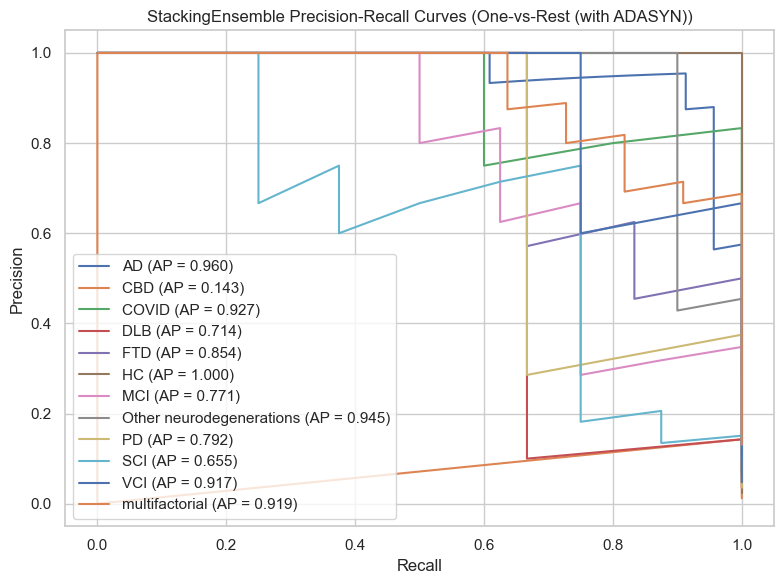


StackingEnsemble model training and evaluation complete.

Building GaussianNaiveBayes Model
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]
Cross-validation accuracy (default params): 0.6553 ± 0.0130

Performing hyperparameter tuning...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'var_smoothing': 1e-09}
Best cross-validation score: 0.6553

Training final model on full dataset...

Test Set Performance:
Accuracy: 0.6310
ROC AUC: 0.9052

Confusion Matrix:
[[17  0  0  4  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  1  0  0  0  0

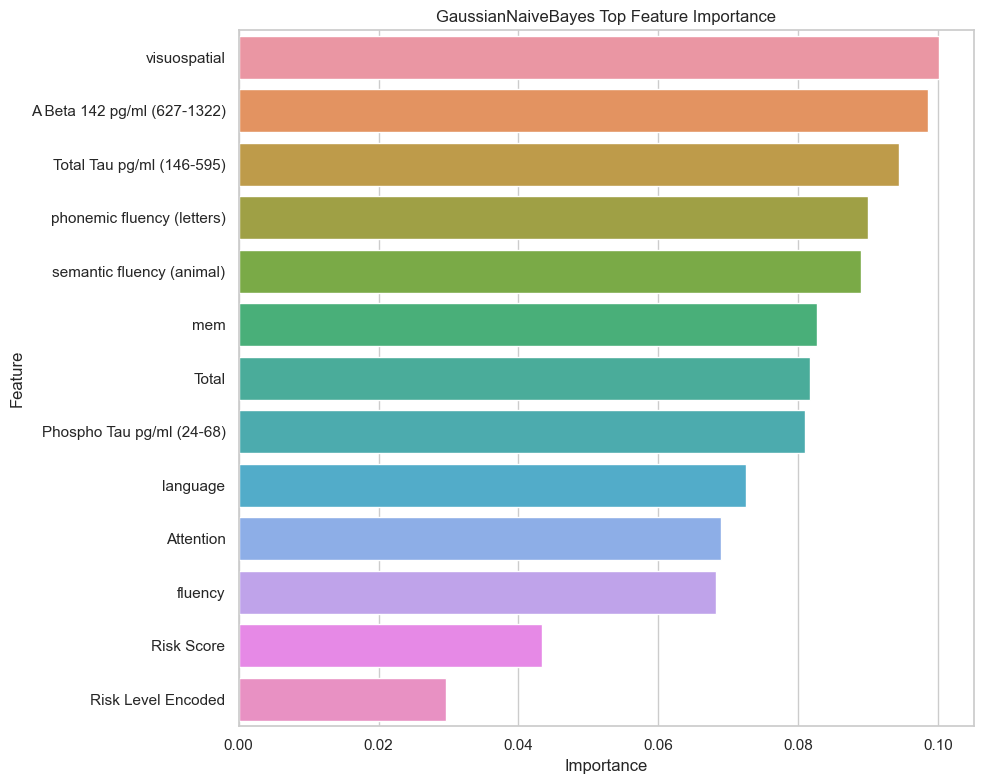

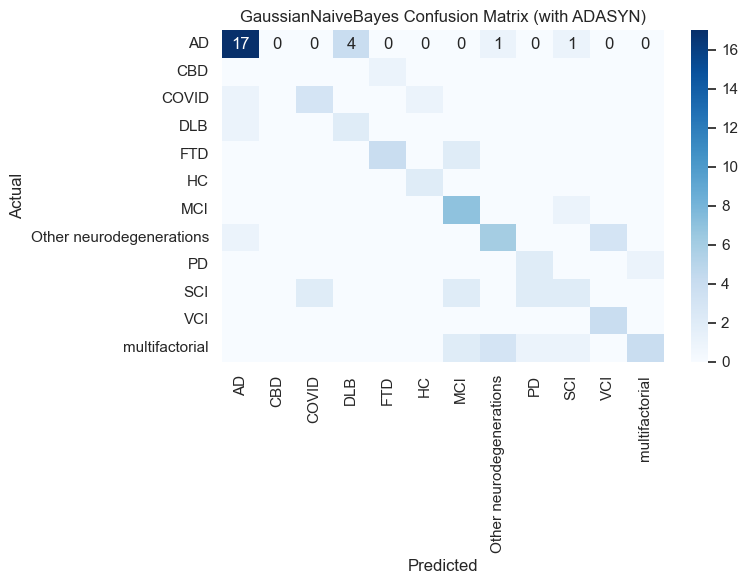

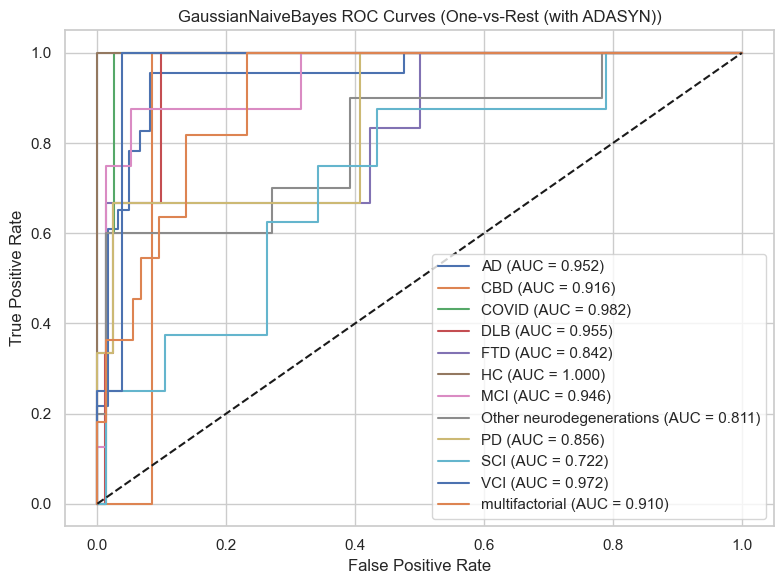

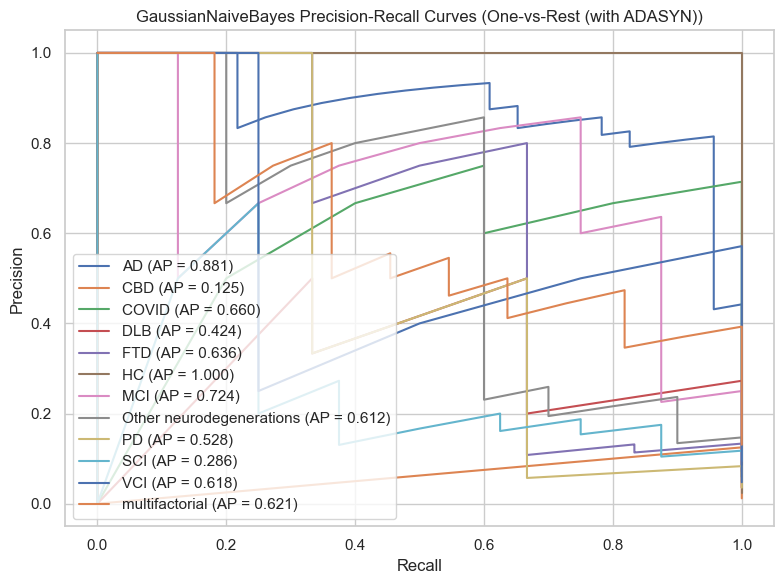


GaussianNaiveBayes model training and evaluation complete.

Building SelfNormalizingNN (SNN) Model with PyTorch
Using device: cpu
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]

Training PyTorch model with early stopping...
Epoch 10/200, Train Loss: 1.2166, Val Loss: 1.1618
Epoch 20/200, Train Loss: 0.9252, Val Loss: 0.9621
Epoch 30/200, Train Loss: 0.7420, Val Loss: 0.8616
Epoch 40/200, Train Loss: 0.6304, Val Loss: 0.7992
Epoch 50/200, Train Loss: 0.5258, Val Loss: 0.7907
Epoch 60/200, Train Loss: 0.4658, Val Loss: 0.7437
Epoch 70/200, Train Loss: 0

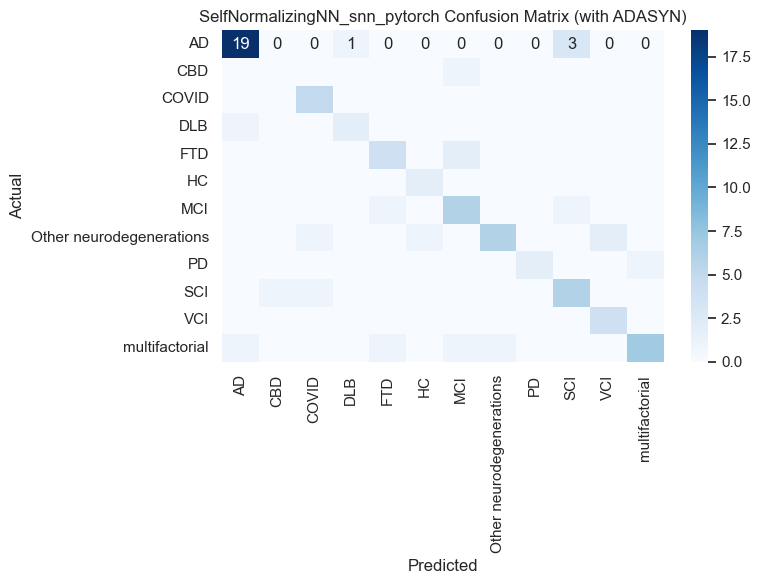

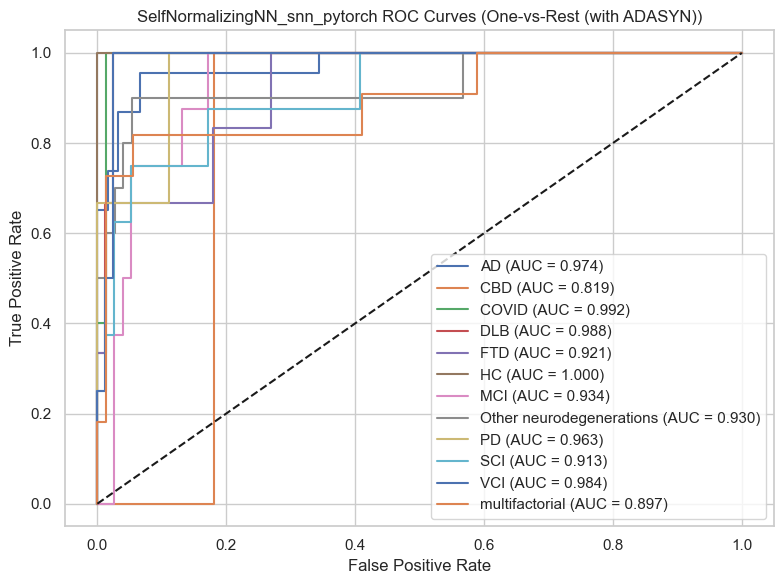

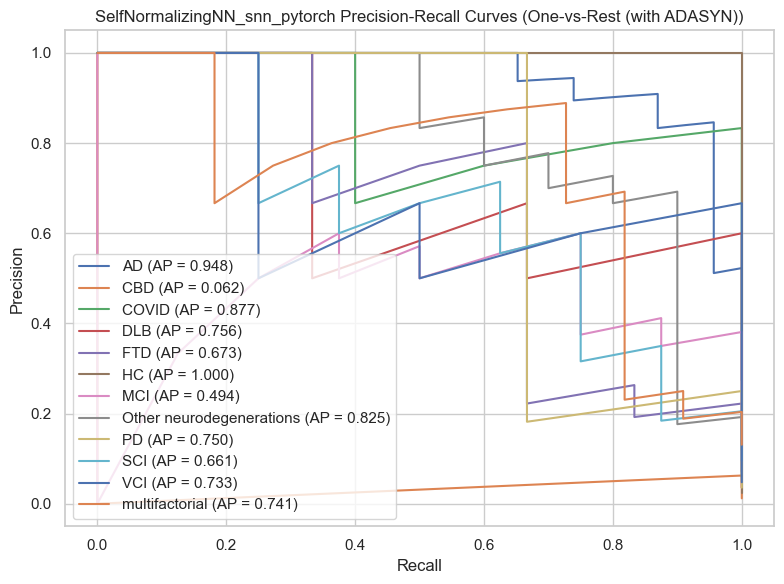

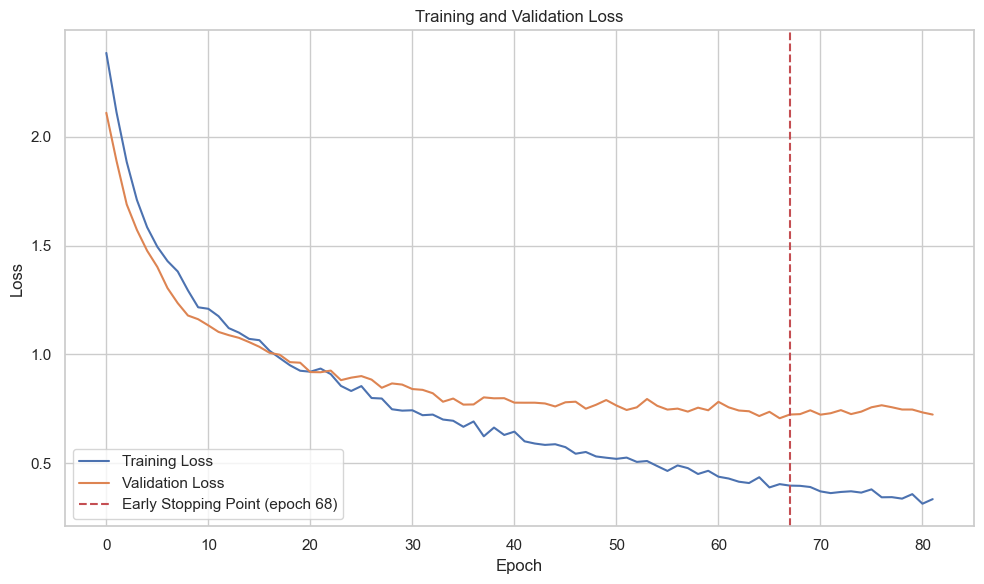


SelfNormalizingNN (snn) PyTorch model training and evaluation complete.

Building AttentionNN (ATT) Model with PyTorch
Using device: cpu
Loaded data with 423 rows and 51 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 332, Test set size: 84
Class distribution in training set: [89  4 22 13 26  7 30 39 11 34 16 41]
Detected class imbalance (ratio: 22.25). Applying ADASYN.
After ADASYN - Training set size: 1056
Class distribution after ADASYN: [89 90 90 85 87 88 83 86 92 91 87 88]

Training PyTorch model with early stopping...
Epoch 10/200, Train Loss: 1.7914, Val Loss: 1.6079
Epoch 20/200, Train Loss: 1.4524, Val Loss: 1.2999
Epoch 30/200, Train Loss: 1.2469, Val Loss: 1.1221
Epoch 40/200, Train Loss: 1.1047, Val Loss: 0.9284
Epoch 50/200, Train Loss: 0.9553, Val Loss: 0.7697
Epoch 60/200, Train Loss: 0.8918, Val Loss: 0.8108
Epoch 70/200, Train 

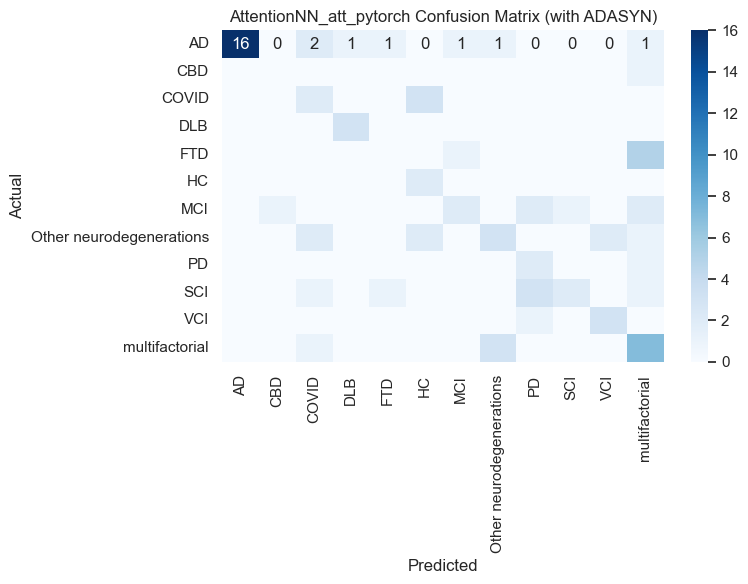

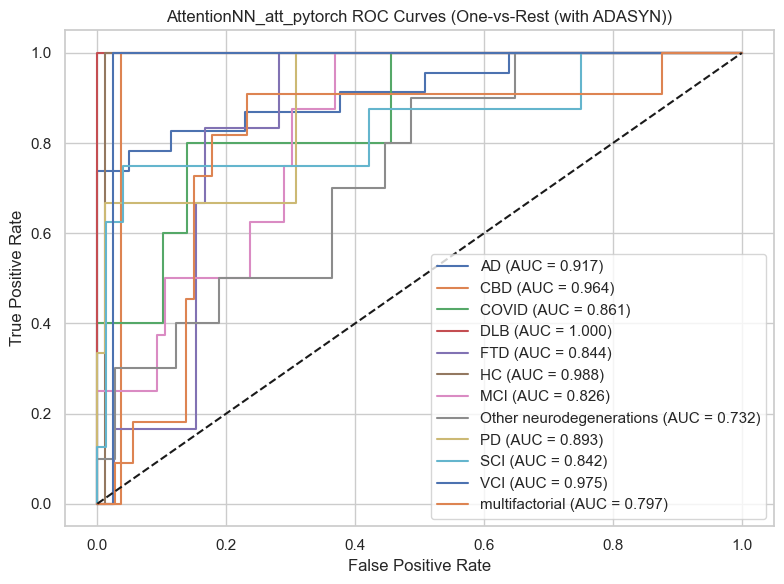

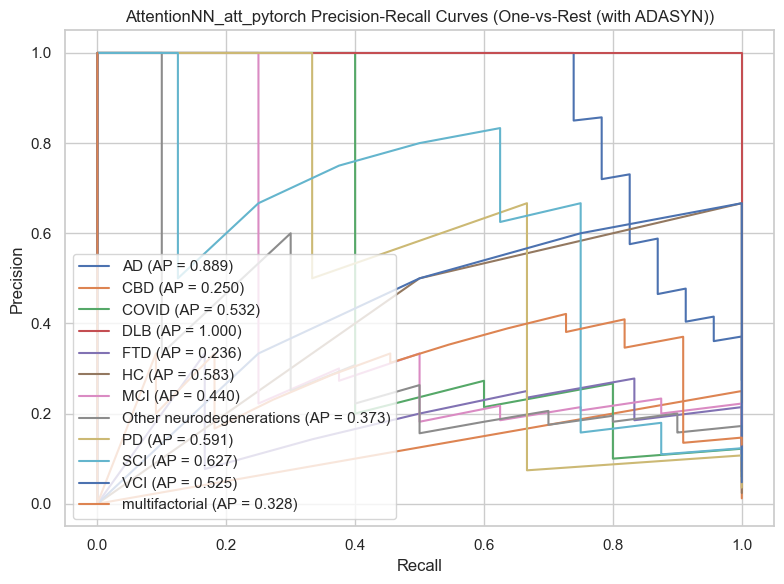

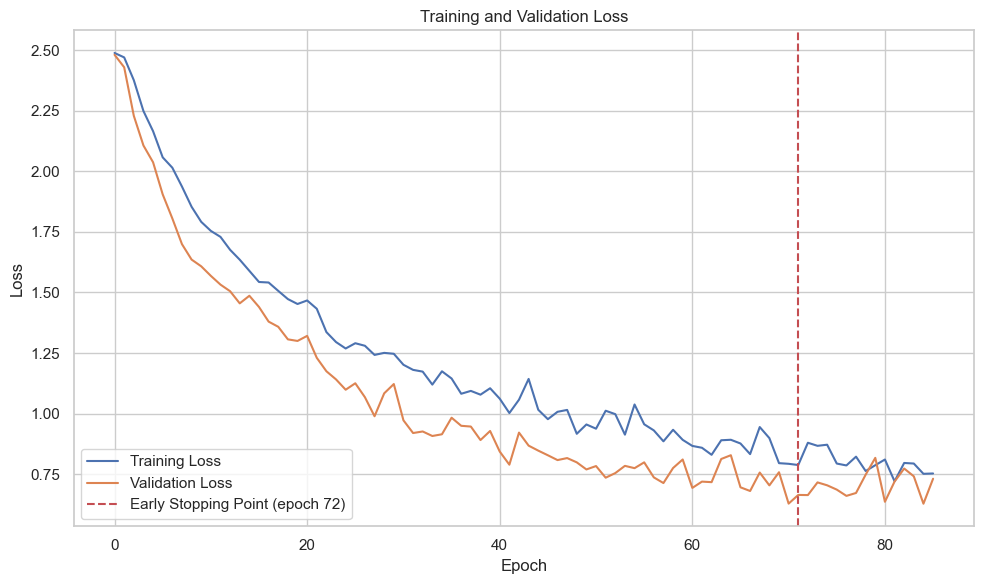


AttentionNN (att) PyTorch model training and evaluation complete.

Model Comparison (Accuracy):
                Model  Accuracy   ROC_AUC
1        RandomForest  0.833333  0.935190
0             XGBoost  0.821429  0.974793
6    StackingEnsemble  0.809524  0.963855
2        DecisionTree  0.785714  0.850587
8   SelfNormalizingNN  0.750000  0.942887
3                 SVM  0.666667  0.934596
4       NeuralNetwork  0.666667  0.935149
5                 KNN  0.630952  0.827179
7  GaussianNaiveBayes  0.630952  0.905237
9         AttentionNN  0.500000  0.886521

Model Comparison (ROC AUC):
                Model  Accuracy   ROC_AUC
0             XGBoost  0.821429  0.974793
6    StackingEnsemble  0.809524  0.963855
8   SelfNormalizingNN  0.750000  0.942887
1        RandomForest  0.833333  0.935190
4       NeuralNetwork  0.666667  0.935149
3                 SVM  0.666667  0.934596
7  GaussianNaiveBayes  0.630952  0.905237
9         AttentionNN  0.500000  0.886521
2        DecisionTree  0.785714  0

In [ ]:

if __name__ == "__main__":
    # Path to your imputed data
    data_path = 'cognid_with_risk_scores.xlsx'
    cleaned_data_path = 'ccognid_with_risk_scores_cleaned.xlsx'
    
    # Cleaning the data
    df = pd.read_excel(data_path)
    
    # Removing rows for whom the data for medical reports is not present
    if 'Risk Score' in df.columns:
        missing_count = df['Risk Score'].isna().sum()
        if missing_count > 0:
            print(f"Imputing {missing_count} missing values in 'Risk Score' with 0")
            df['Risk Score'] = df['Risk Score'].fillna(0)
    
    if 'Risk Level' in df.columns:
        missing_count = df['Risk Level'].isna().sum()
        if missing_count > 0:
            print(f"Imputing {missing_count} missing values in 'Risk Level' with 'Not Recorded'")
            df['Risk Level'] = df['Risk Level'].fillna('Not Recorded')

    label_encoder = LabelEncoder()
    df['Risk Level Encoded'] = label_encoder.fit_transform(df['Risk Level'])
    print("Label Encoding complete")
    
    # Target column (diagnosis classification)
    target_column = 'Completed Diagnosis'
    
    # Removing Rows where diagnosis is still under investigation
    before_rows = df.shape[0]
    df = df.drop(df[df[target_column]=='No diagnosis'].index)
    
    print(f'Removed {before_rows - df.shape[0]} rows from {target_column} where value was No diagnosis')
    
    df.to_excel(cleaned_data_path, index=False)
    
    
    